# A Brief Introduction to Graph Convolutional Networks (GCN)

## Terminology

 - __Node__ : A node is a person in the graph. Every person has a corresponding node and every node corresponds to one person. It is represented  by circles in the graph.
 - __Edge__ : It is the line joining two nodes in a graph. Presence of an edge between two nodes indices that the two nodes have interacted with each other. It is represented by straight lines in the graph.
 - __Adjacency Matrix__ : It is a method of representing a graph using only a square Matrix. Suppose there are N nodes there in a graph then there will be N rows and N columns in the corresponding adjacency matrix. The i'th row will contain a 1 in the j'th column if there is an edge between the i'th and the j'th node otherwise it will contain a 0.
 ![img](adj_mat.jpg)
 
 

## What is GCN

GCN is basically a neural network that operates on a graph. It will take a graph as an input and give some meaningful output. It is a very powerful method that can work on a large number of graphs with very little about of human help. Even if the information about only 2 nodes is given it can predict for the graph with very high accuracy rate.  One possible application of GCN is in the Facebook's friend prediction algorithm. Consider three people A, B and C. Given that A is a friend of B, B is a friend of C. You are also given some information about each person, now you have to predict whether A is friend of C. Today we will be discussing about a simpler version of this problem.

Now first I will show you a very simple method for predicting the Friend Prediction problem and then we will generalize this to work with much better success rate.

#### Problem Statement: You are given N persons and also a graph where there is an edge between two people if they are friends.  Now you have to predict whether two persons will become friend in future or not.

A simple graph corresponding to this problem is:
![img](friends_graph.png)
Here person (1,2) are friends, similarly (2,3), (3,4), (4,1), (5,6),(6,8), (8,7), (7,6) are also friends.

Now we are interested in finding out whether a given pair of person will become friend in future or not. Lets say that the pair we are interested in in (1,3), now since they have 2 common friends implies they have a high chance of becoming friends, whereas the node (1,5) have no friend in common so they are much less likely to become friends.

Lets take another example:
![img](friends_graph2.png)
Here (1,12) are much more likely to become friends than say (3, 11).

So we can say that nodes that are closer are much more likely to be similar than the nodes that are far from each other.

Now the next question that arises is 'How to implement this?'. GCN's implement it in a way similar to CNNs. In CNN we apply a filter on the original image to get the representation in next layer. Similarly in GCN we apply a filter which creates the next layer representation. Mathematically, 
                            H(l+1)=f(A, H(l)) where A is the adjacency matrix
A very simple example of f is
                            f(A, H(l),X)=RELU( A*H(l)*W(l))

But in this we will be facing two major problems:
 - Value of node is not a function of its previous value : As you can see the value of a node is only a function of its neighbours but not of the node itself. We can overcome this by adding self loops, that is an edge starting and ending on the same node, in this way a node will become a neighbour of itself.
 - Nodes that have large number of neighbours will get much more input from them and hence will have a large value, and this value will grow very fast. To deal with this we will be using normalisation ,i.e, reduce all values in such a way that the values dont explode.


In this tutorial we will be using the following choices of 'f' functions.
                    output = sigmoid( A_hat * RELU( A_hat * X * W(0) ) * W(1)), where A_hat= D^(-0.5) *(A+I) *D^(-0.5) , [https://arxiv.org/pdf/1901.00596.pdf
                    ]
                    

# Implementing GCN in PyTorch

We are now ready to put all of the tools together to deploy your first fully-functional Graph Convolutional network. In this tutorial we will be using GCN on the 'Zachary karate club network'. We will be using the 'Semi Supervised Graph Learning Model' proposed in ------.



### Zachary Karate Club

During the period from 1970-1972, Wayne W. Zachary, observed the people belonging to a local karate club. He represented these people as nodes in a graph. And added a edge between a pair of people if they interacted with each other. The result was a the graph shown below.
![img](karate_club.png)

During the study an interesting event happened. A conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. 

Using the graph that he had found earlier, he tried to predict which member will go to which half. And surprisingly he was able to predict the decision of all the members except for node 9 who went with Mr. Hi instead of John A. Zachary used the maximum flow – minimum cut Ford–Fulkerson algorithm for this. We will be using a different algorithm today, hence it is not required to know about Ford-Fulkerson algorithm.

Here we will be using the Semi Supervised Graph Learning Method. Semi Supervised means that we have labels for only some of the nodes and we have find the labels for other nodes. Like in this example we have the labels for only the nodes belonging to 'John A' and 'Mr. Hi', we have not been provided with labels for any other member and we have be predict that only on the basis of the graph given to us.

### Loading Required Libraries
In this post we will be using PyTorch and Matplotlib.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### The Convolutional Layer
First we will be creating the GCNConv class, which will serve as the Layer creation class. Every instance of this class will be getting Adjacency Matrix as input and will be outputing 'RELU(A_hat * X * W)', which the Net class will use.

In [2]:
class GCNConv(nn.Module):
    def __init__(self, A, in_channels, out_channels):
        super(GCNConv, self).__init__()
        self.A_hat=A+torch.eye(A.size(0))
        self.D=torch.diag(torch.sum(A,1))
        self.D=self.D.inverse().sqrt()
        self.A_hat=torch.mm(torch.mm(self.D, self.A_hat), self.D)
        self.W=nn.Parameter(torch.rand(in_channels,out_channels, requires_grad=True))
    def forward(self, X):
        out=torch.relu(torch.mm(torch.mm(self.A_hat, X), self.W))
        return out

The Net  class will combine multiple Conv layer.

In [3]:



class Net(torch.nn.Module):
    def __init__(self,A, nfeat, nhid, nout):

        super(Net, self).__init__()
        self.conv1=GCNConv(A,nfeat, nhid)
        self.conv2=GCNConv(A,nhid, nout)
        
    def forward(self,X):
        H=self.conv1(X)
        H2=self.conv2(H)
        return H2
        


'A' is the adjacency matrix, it contains 1 at a position (i,j) if there is a edge between the node i and node j.

In [4]:
A=torch.Tensor([[0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0],
                [1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
                [1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0],
                [1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1],
                [0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1],
                [0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,1,0,1],
                [0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0]
                ])



In this example we have the label for admin(node 1) and instructor(node 34) so only these two contain the class label(0 and 1) all other are set to -1, which means that the predicted value of these nodes will be ignores in the computation of loss function.

In [5]:
target=torch.tensor([1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,0])

X is the feature matrix. Since we dont have any feature of each node, we will just be using the one-hot encoding corresponding to the index of the node.

In [6]:
X=torch.eye(A.size(0))

Here we are creating a Network with 10 features in the hidden layer and 2 in output layer.

In [7]:
T=Net(A,X.size(0), 10, 2)

### Training

In [8]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD(T.parameters(), lr=0.001, momentum=0.9)

In [9]:
loss=criterion(T(X),target)


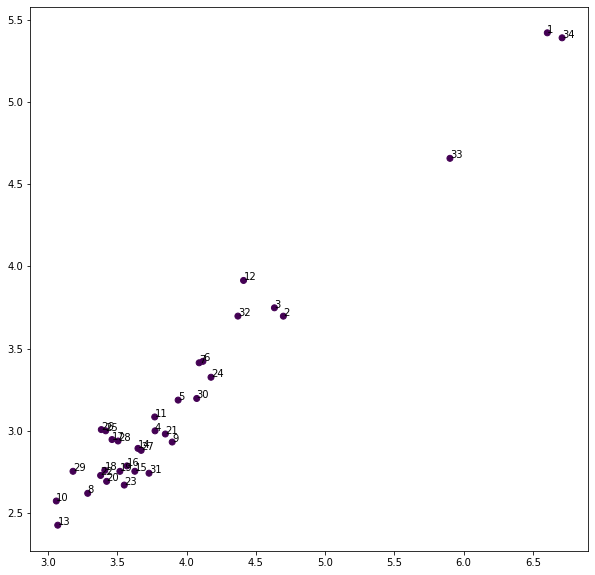

Cross Entropy Loss: = 0.8451317548751831


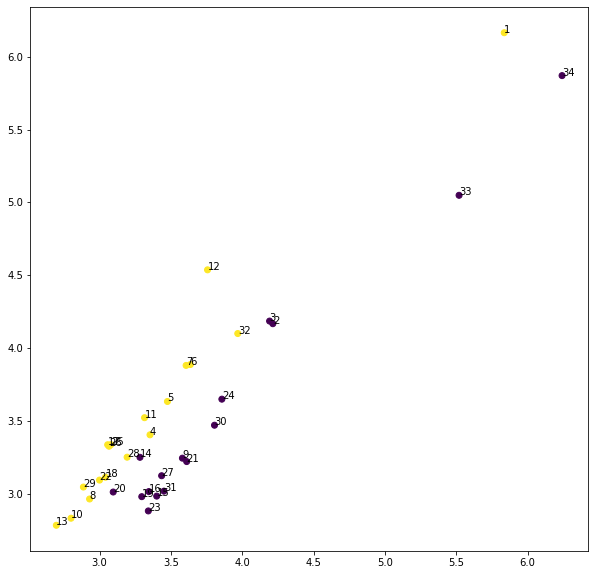

Cross Entropy Loss: = 0.5347617268562317


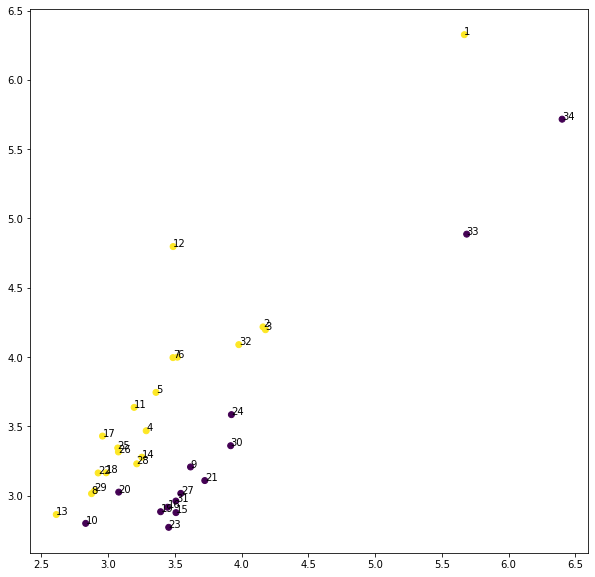

Cross Entropy Loss: = 0.41401195526123047


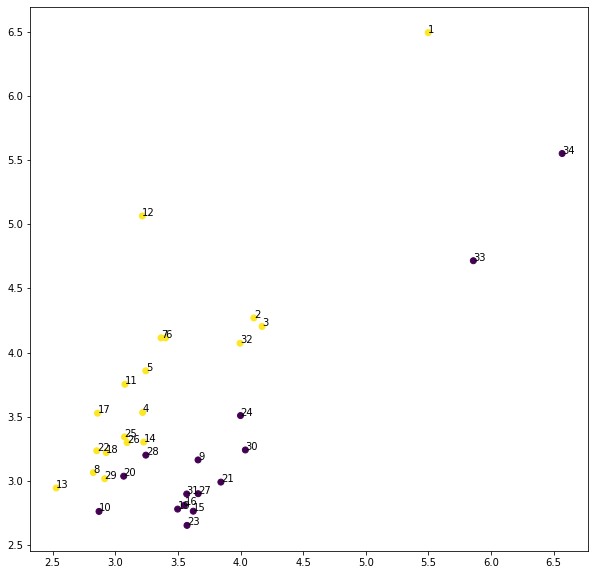

Cross Entropy Loss: = 0.3126193881034851


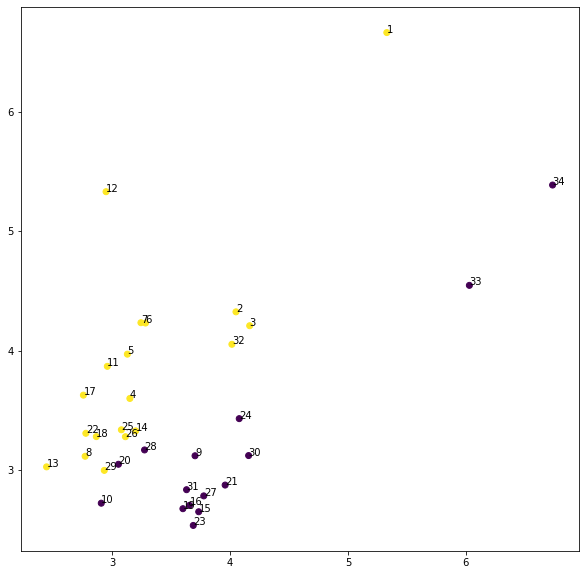

Cross Entropy Loss: = 0.23317551612854004


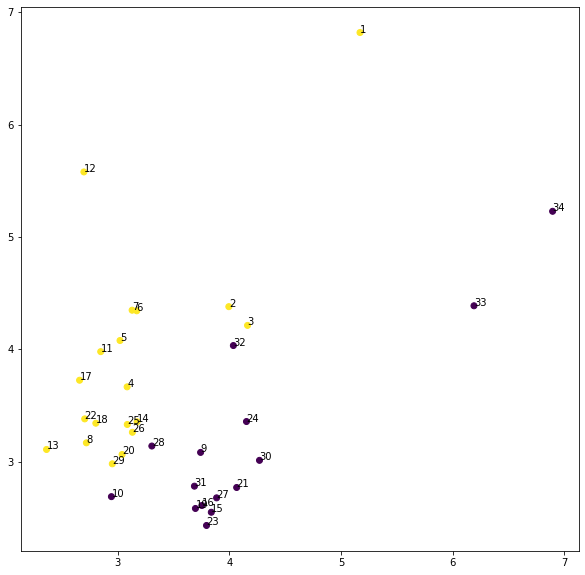

Cross Entropy Loss: = 0.17495040595531464


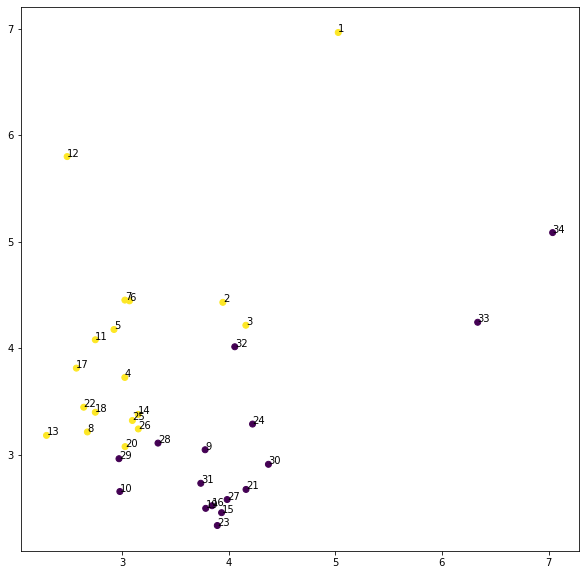

Cross Entropy Loss: = 0.13404732942581177


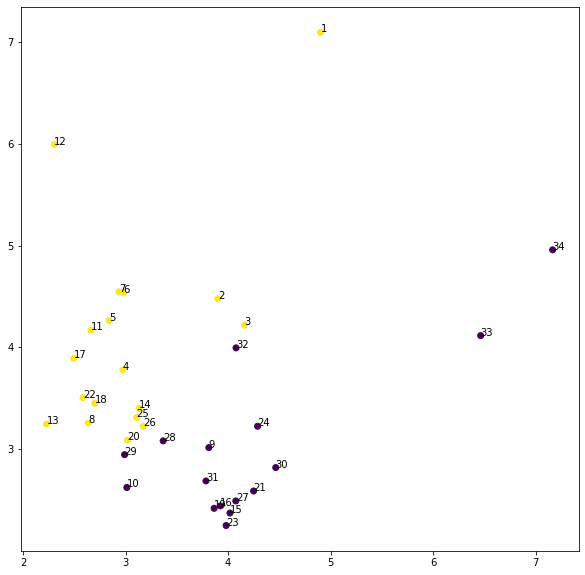

Cross Entropy Loss: = 0.10529579222202301


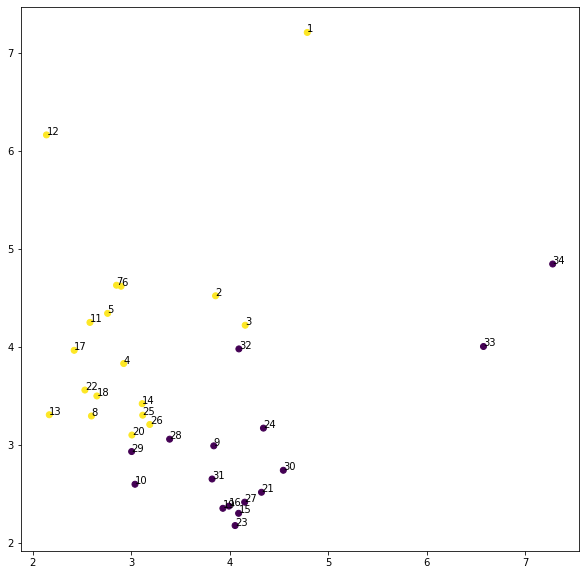

Cross Entropy Loss: = 0.08470766246318817


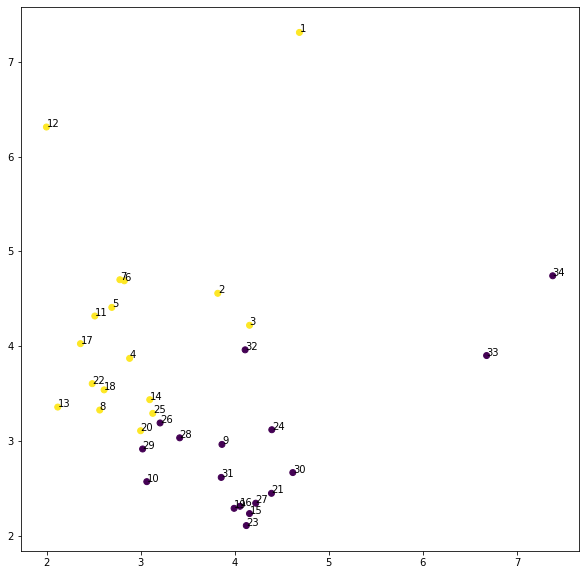

Cross Entropy Loss: = 0.06965996325016022


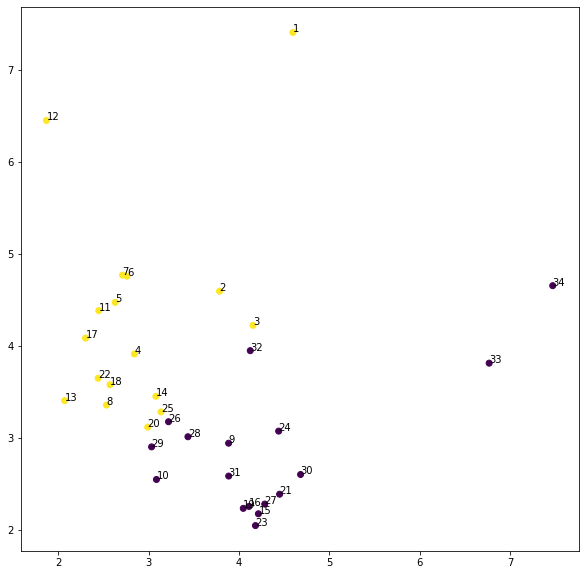

Cross Entropy Loss: = 0.05840793997049332


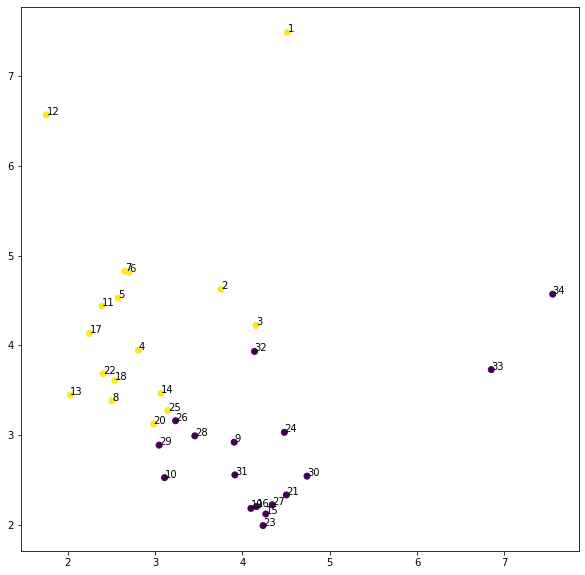

Cross Entropy Loss: = 0.04980340227484703


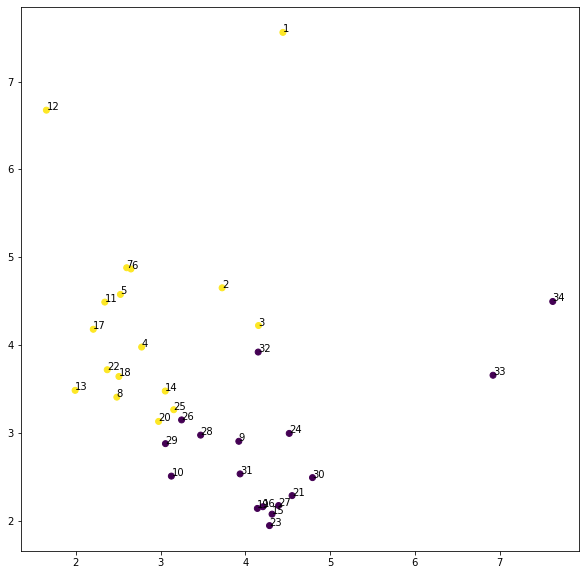

Cross Entropy Loss: = 0.04308512061834335


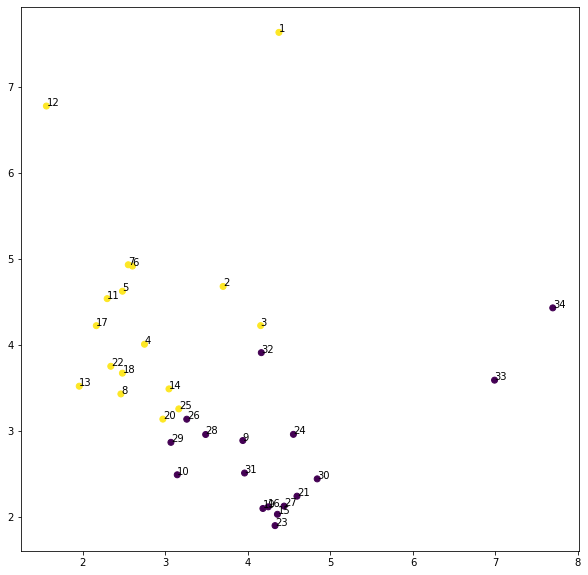

Cross Entropy Loss: = 0.03773987293243408


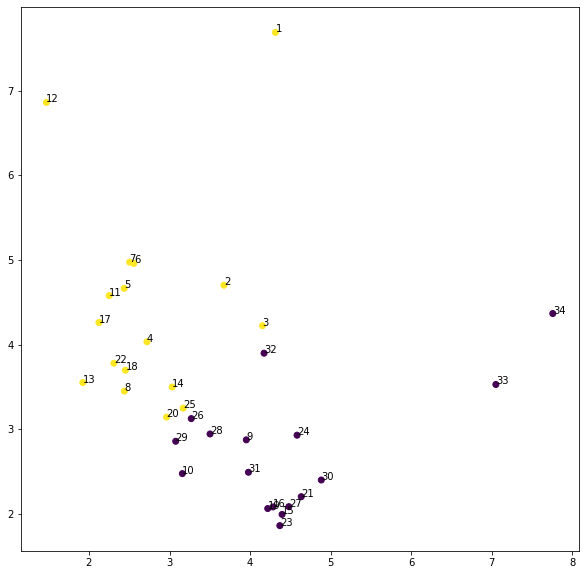

Cross Entropy Loss: = 0.03341490775346756


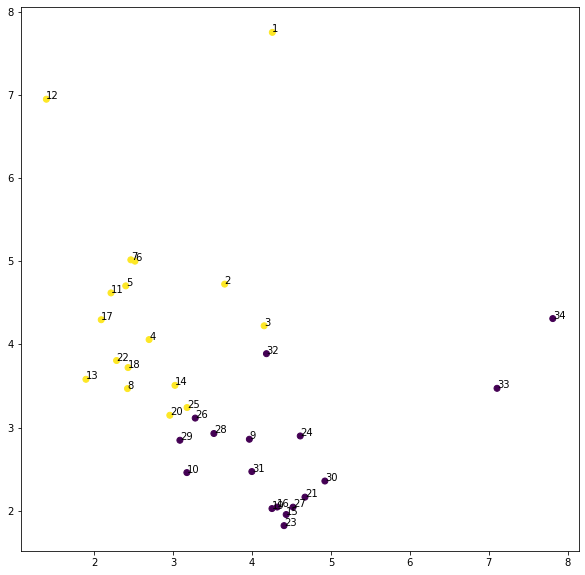

Cross Entropy Loss: = 0.02986333519220352


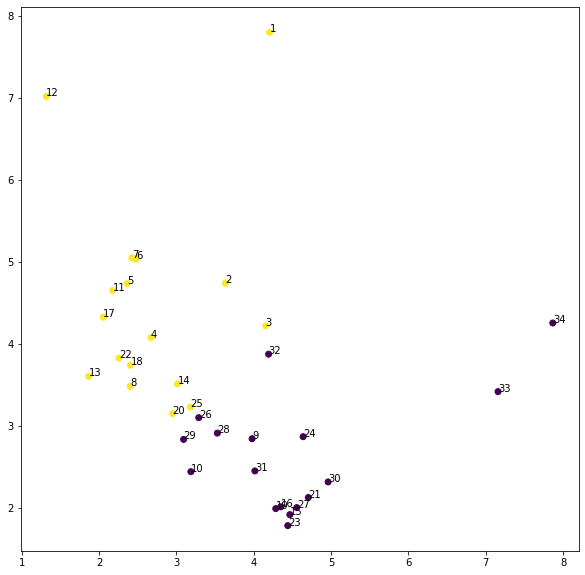

Cross Entropy Loss: = 0.0269462950527668


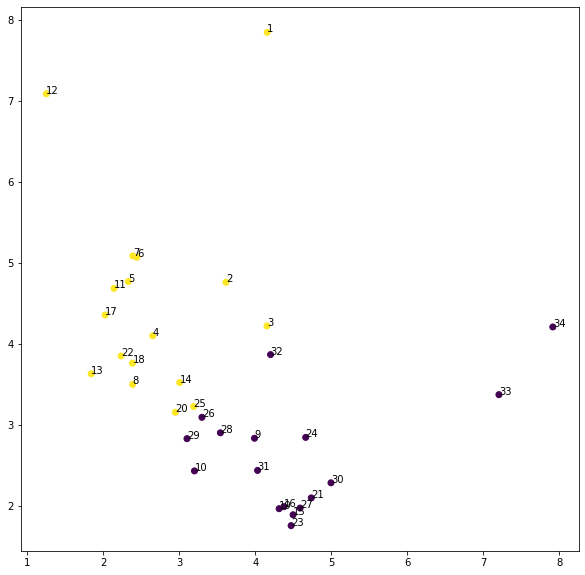

Cross Entropy Loss: = 0.024487465620040894


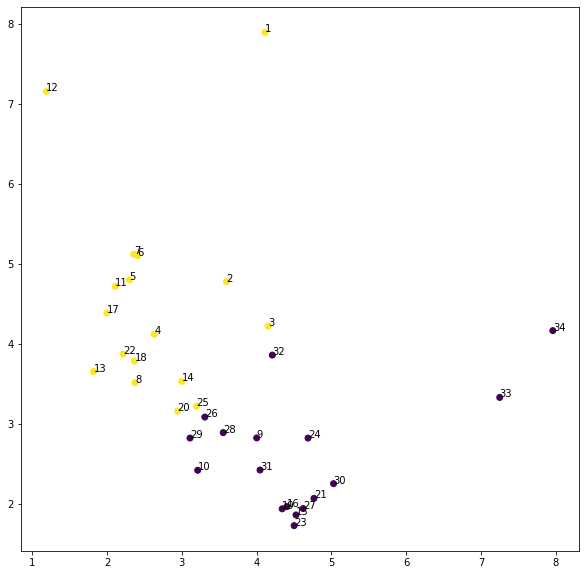

Cross Entropy Loss: = 0.022398581728339195


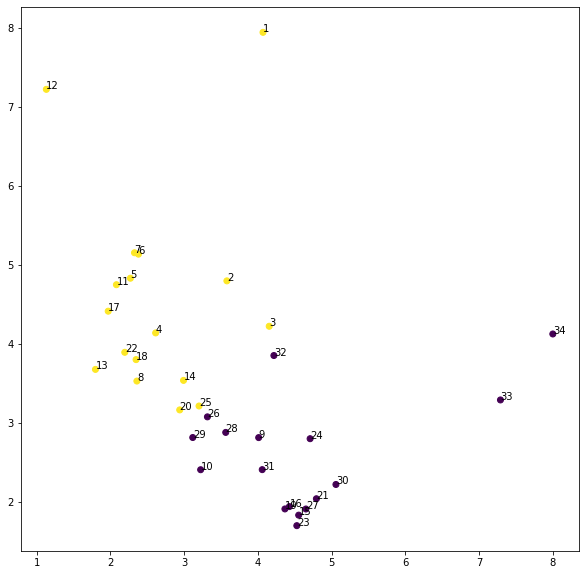

Cross Entropy Loss: = 0.020598888397216797


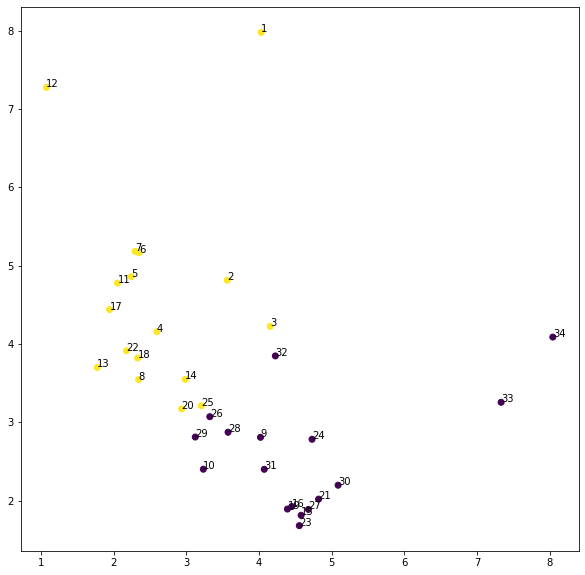

Cross Entropy Loss: = 0.019035518169403076


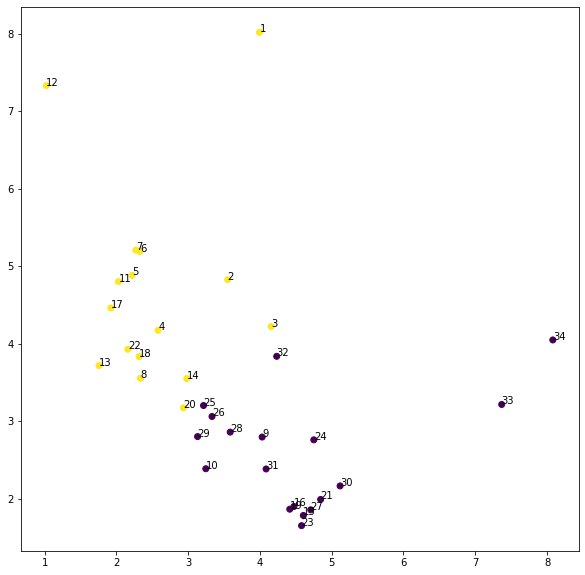

Cross Entropy Loss: = 0.017667243257164955


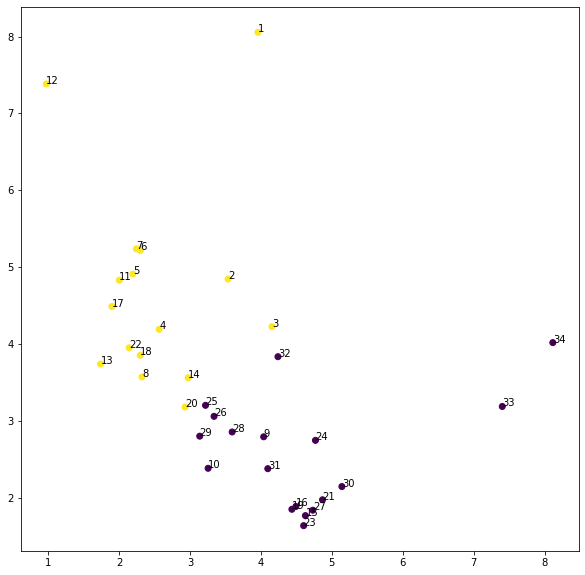

Cross Entropy Loss: = 0.016461685299873352


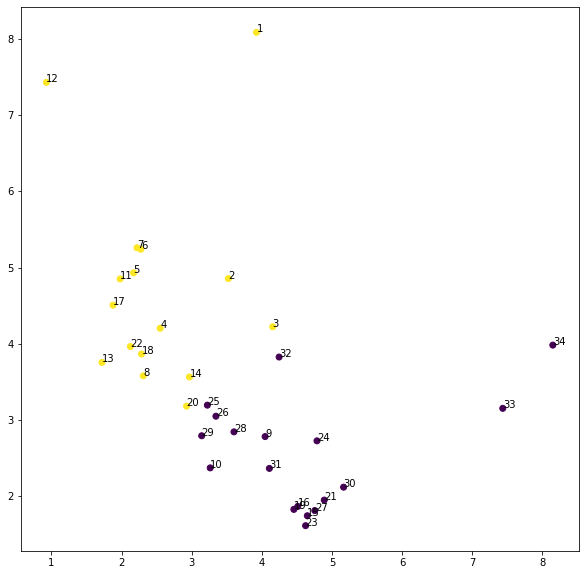

Cross Entropy Loss: = 0.0153928492218256


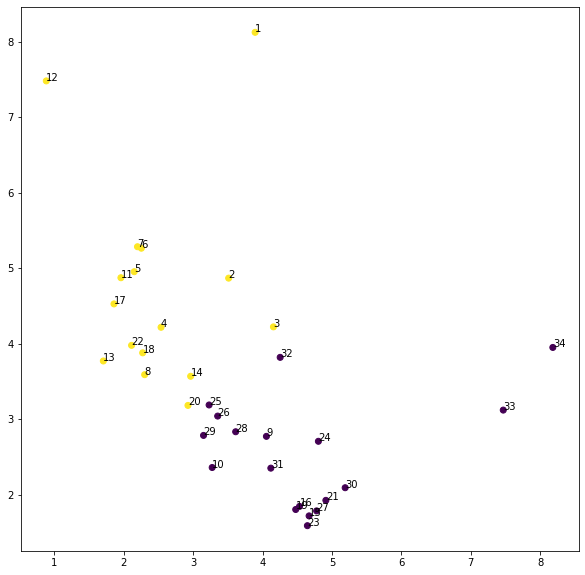

Cross Entropy Loss: = 0.014439965598285198


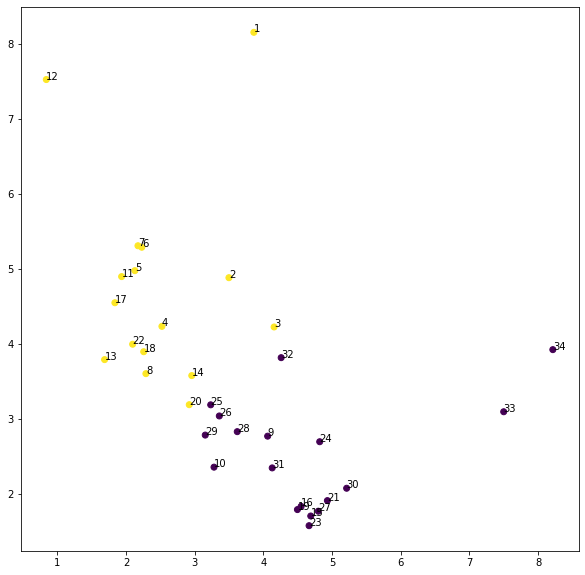

Cross Entropy Loss: = 0.013586137443780899


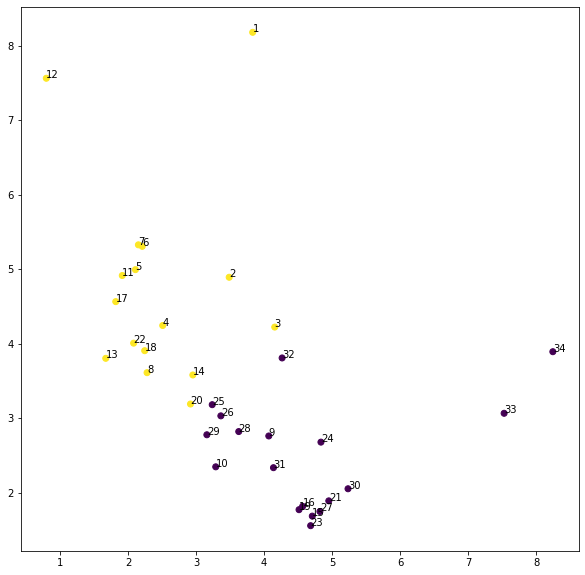

Cross Entropy Loss: = 0.01281732227653265


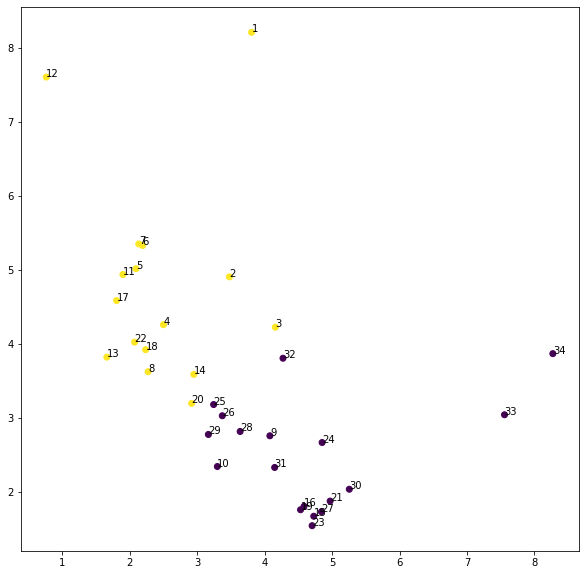

Cross Entropy Loss: = 0.012122055515646935


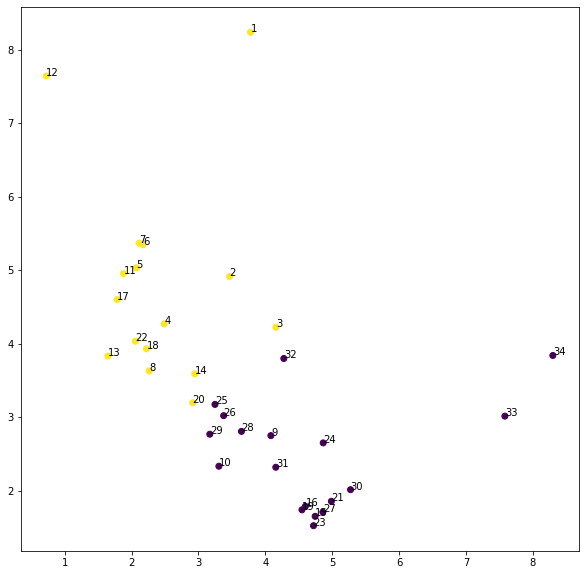

Cross Entropy Loss: = 0.011490829288959503


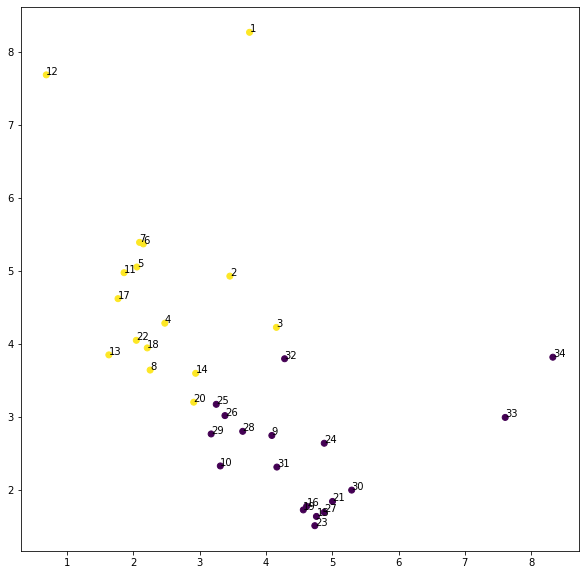

Cross Entropy Loss: = 0.010920226573944092


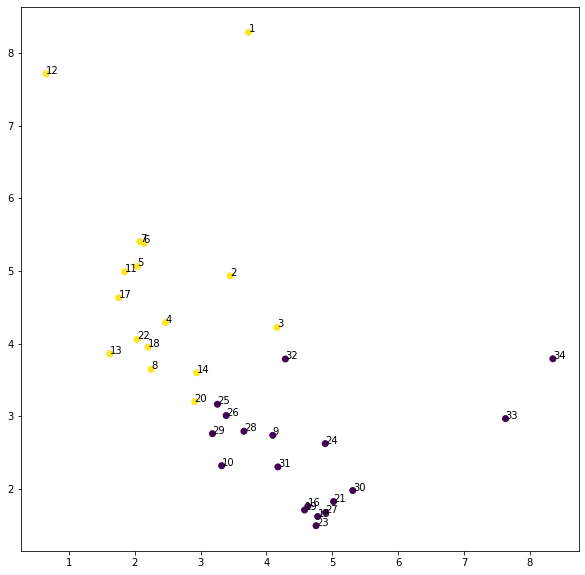

Cross Entropy Loss: = 0.010400854051113129


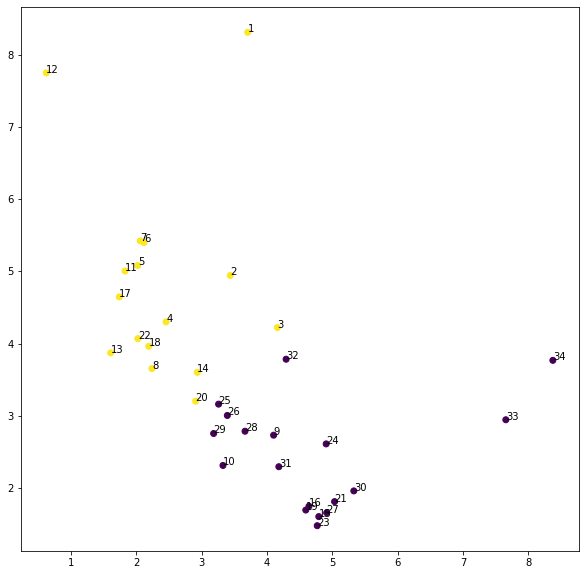

Cross Entropy Loss: = 0.009923764504492283


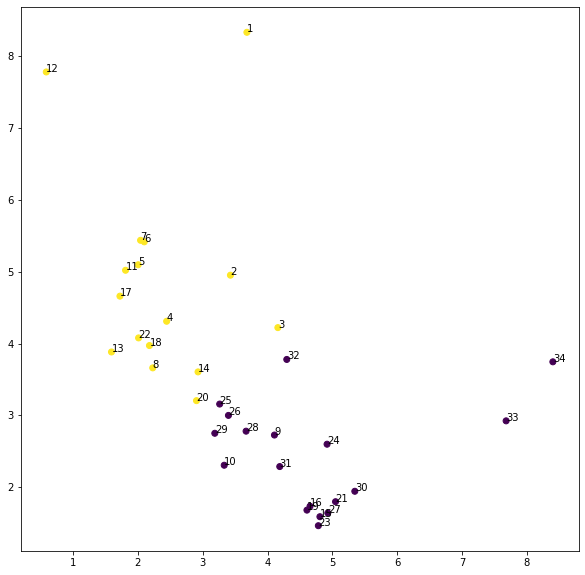

Cross Entropy Loss: = 0.009484292939305305


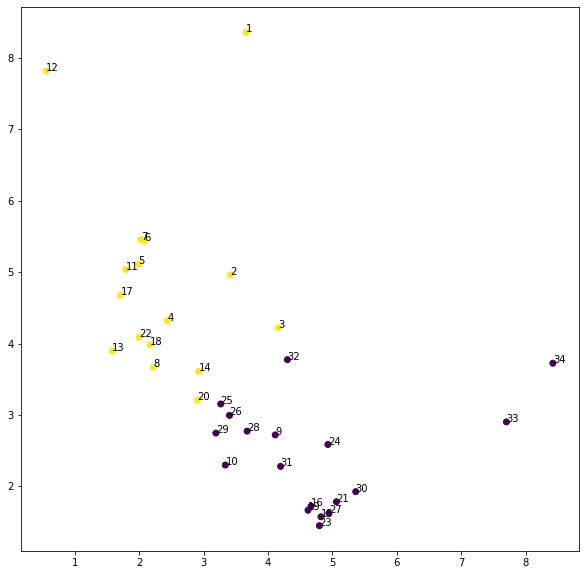

Cross Entropy Loss: = 0.009078356437385082


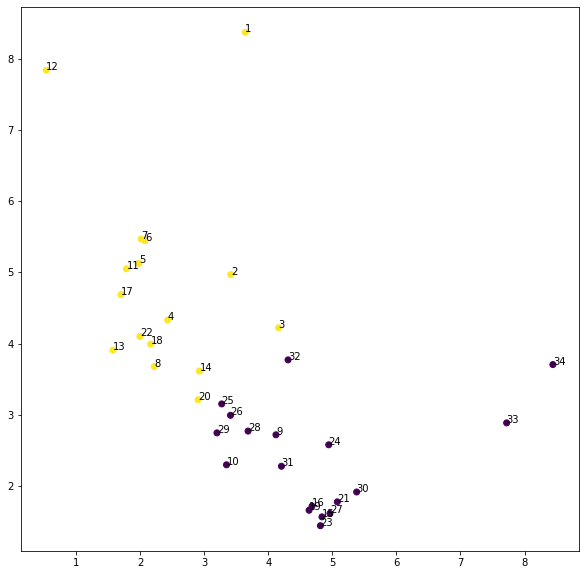

Cross Entropy Loss: = 0.008702389895915985


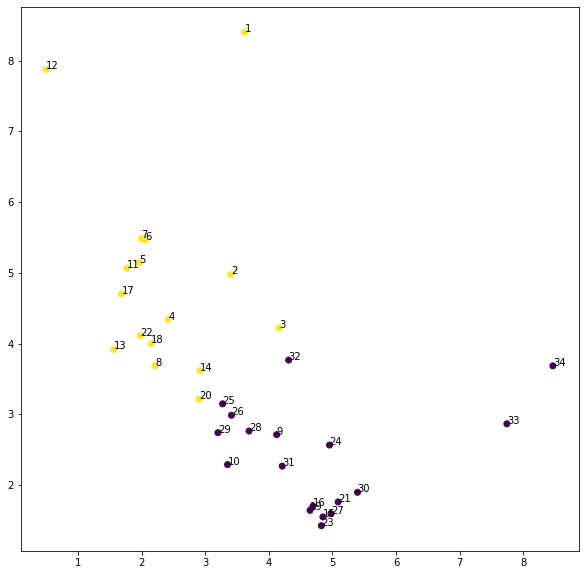

Cross Entropy Loss: = 0.008353354409337044


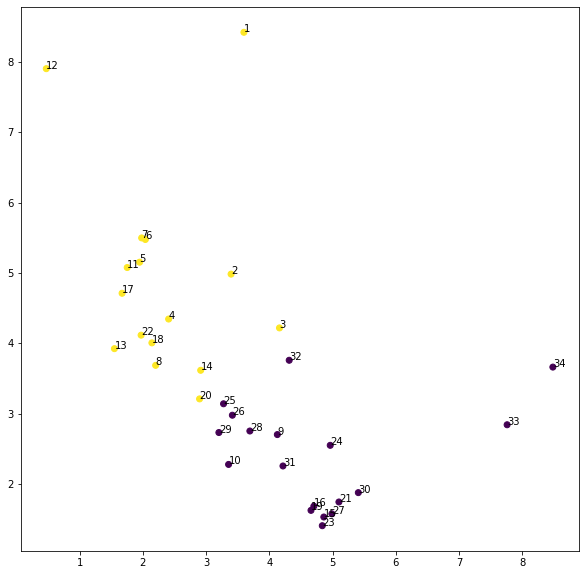

Cross Entropy Loss: = 0.008028557524085045


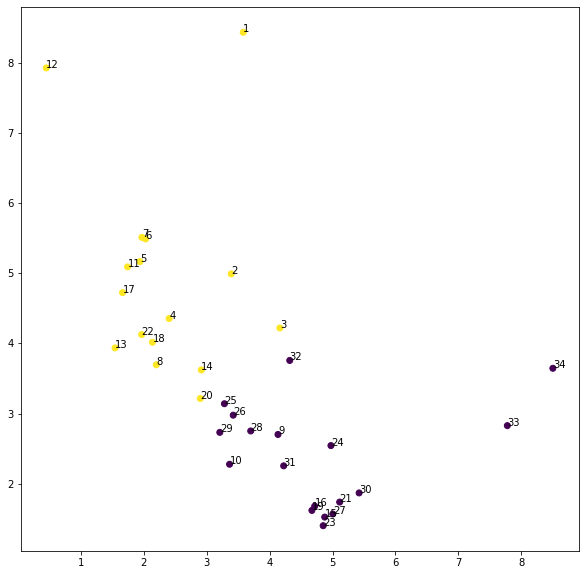

Cross Entropy Loss: = 0.007725716568529606


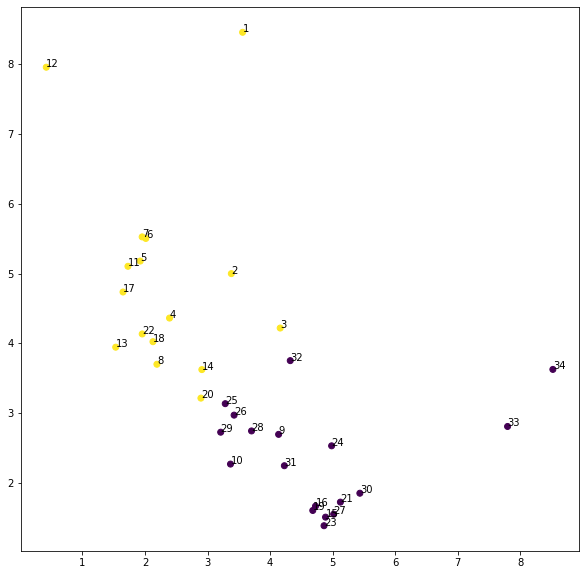

Cross Entropy Loss: = 0.007442781701683998


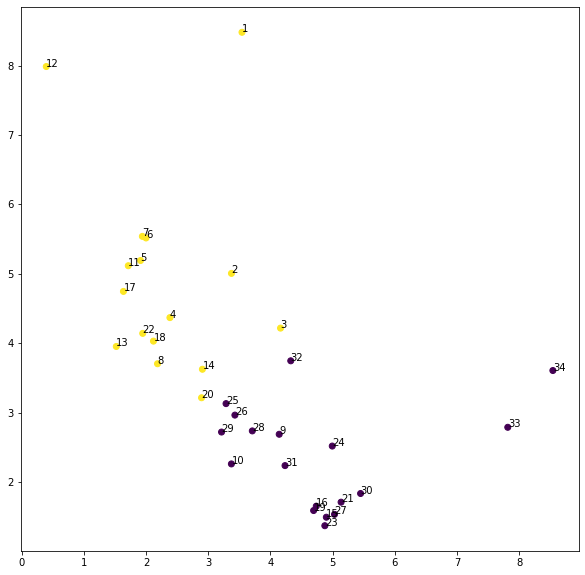

Cross Entropy Loss: = 0.007177875377237797


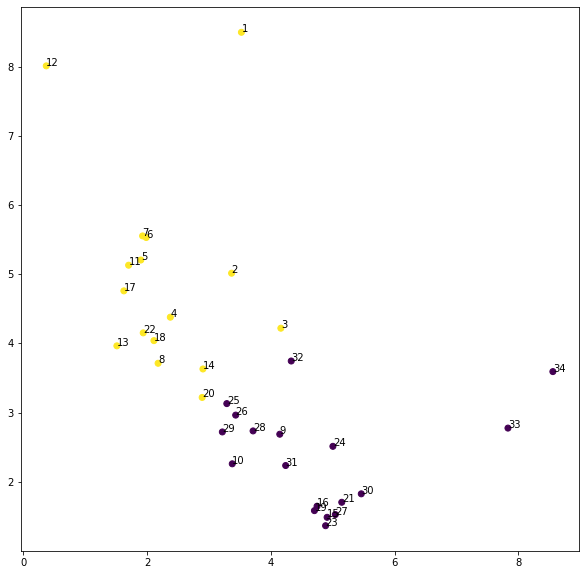

Cross Entropy Loss: = 0.0069314856082201


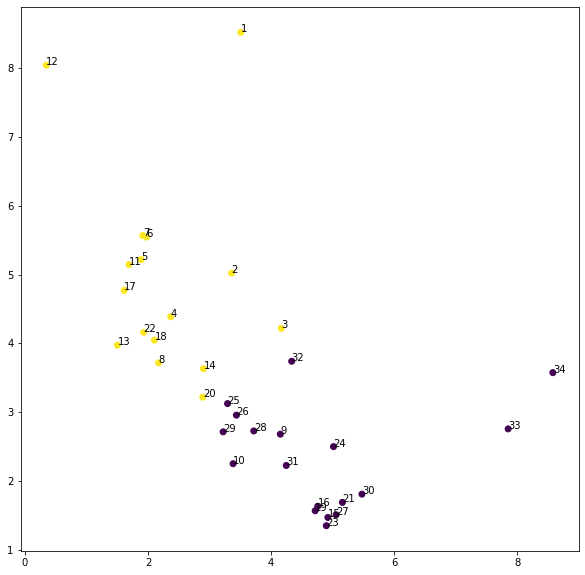

Cross Entropy Loss: = 0.006700843572616577


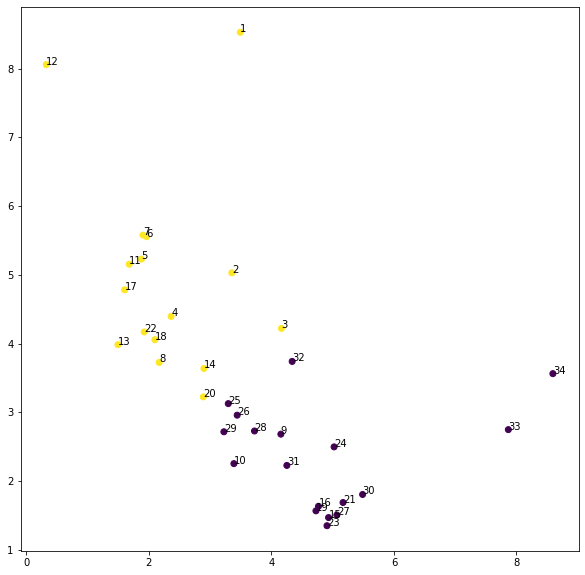

Cross Entropy Loss: = 0.0064837089739739895


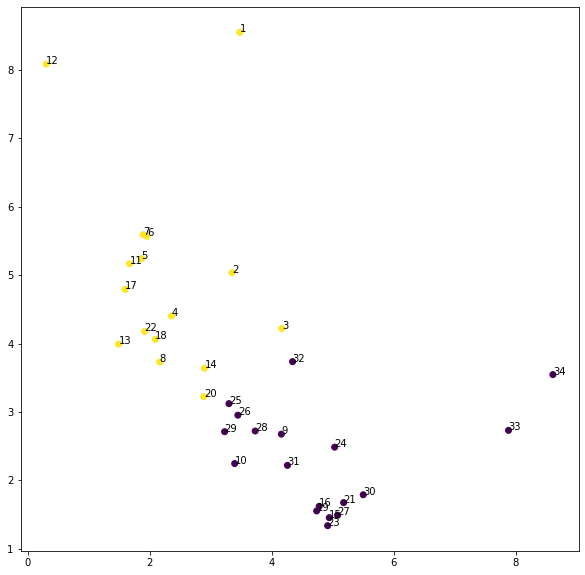

Cross Entropy Loss: = 0.00627890694886446


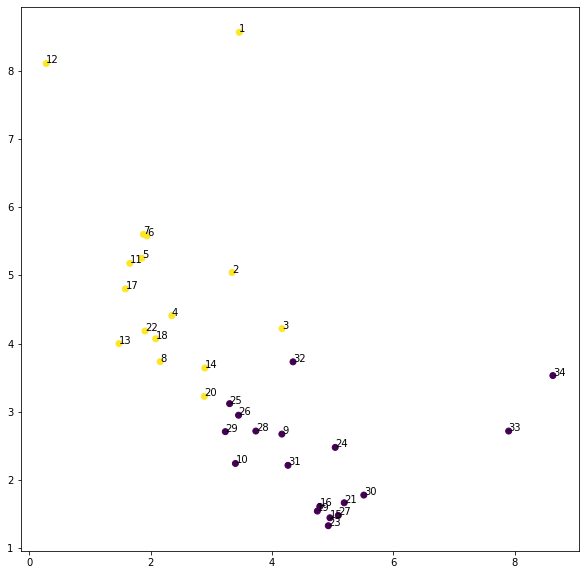

Cross Entropy Loss: = 0.006085438188165426


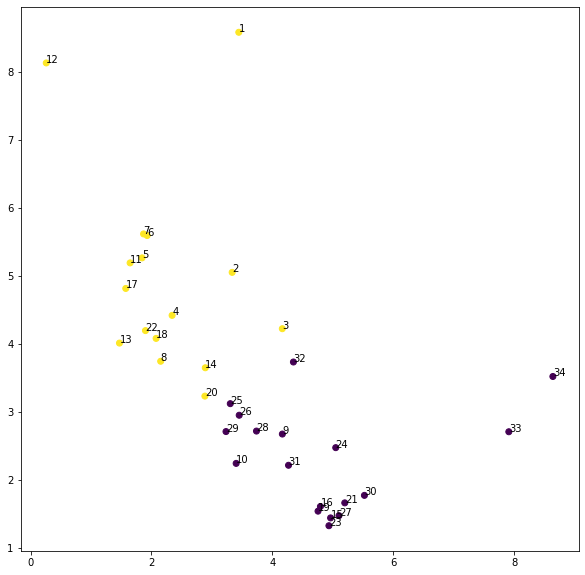

Cross Entropy Loss: = 0.005902419798076153


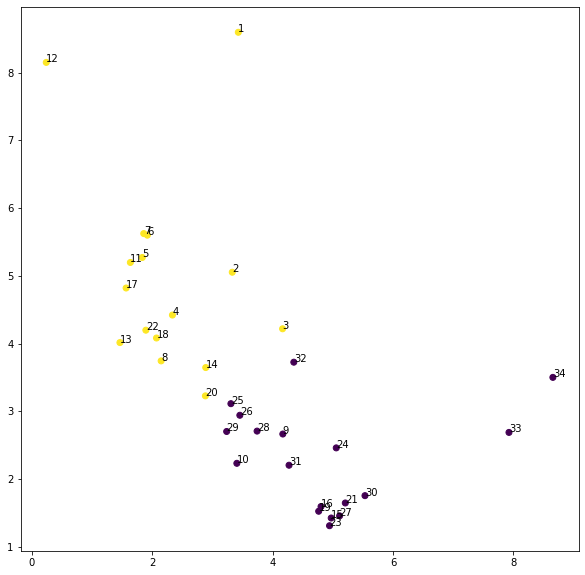

Cross Entropy Loss: = 0.005729205906391144


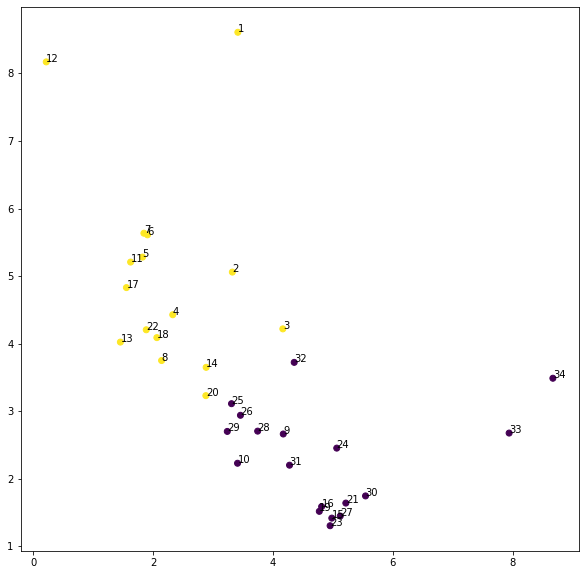

Cross Entropy Loss: = 0.0055648526176810265


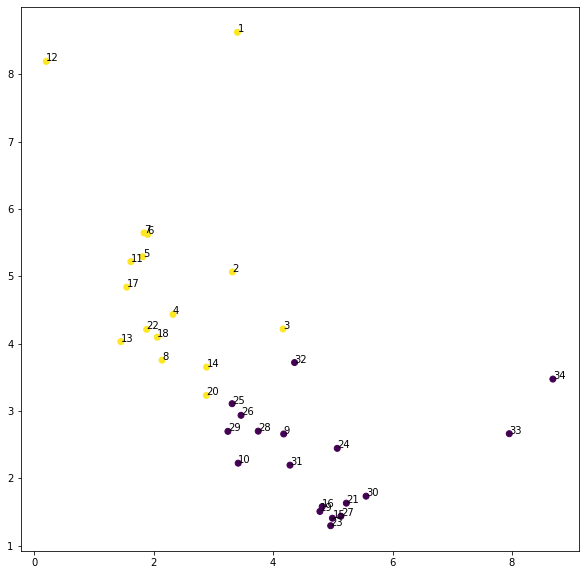

Cross Entropy Loss: = 0.005408891476690769


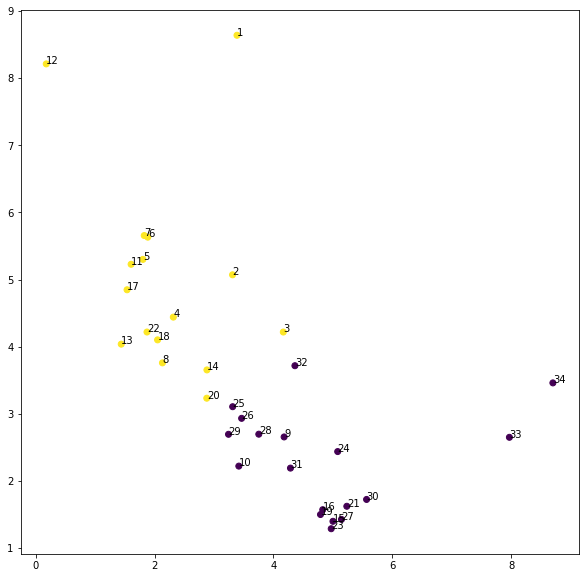

Cross Entropy Loss: = 0.005260612815618515


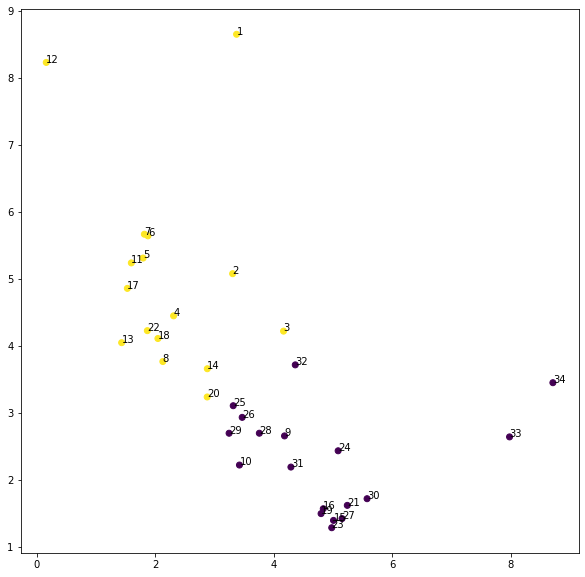

Cross Entropy Loss: = 0.005119547247886658


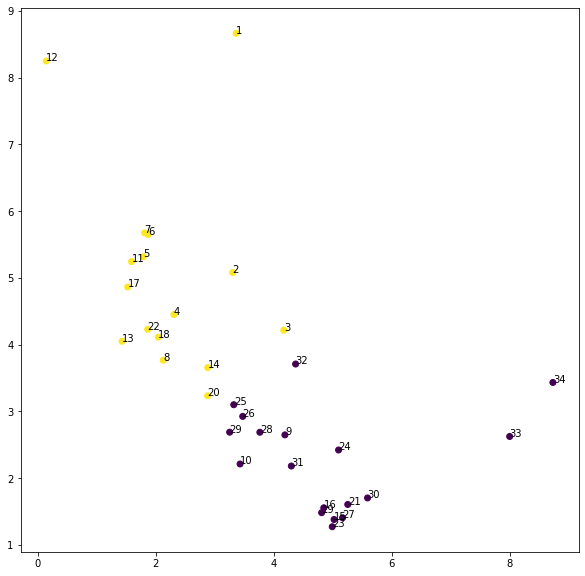

Cross Entropy Loss: = 0.004985223524272442


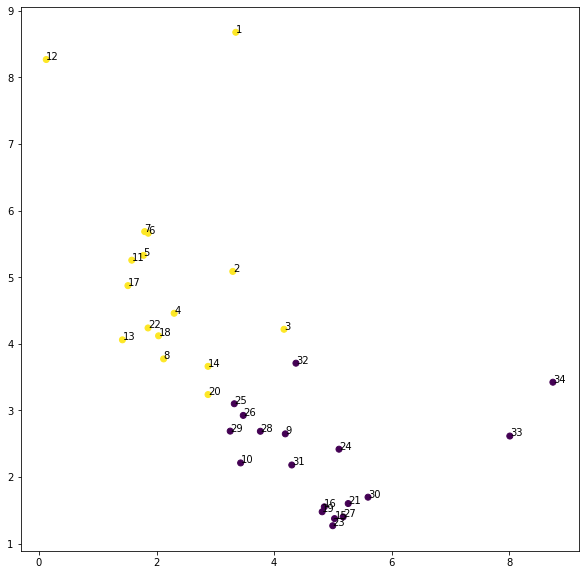

Cross Entropy Loss: = 0.004857050254940987


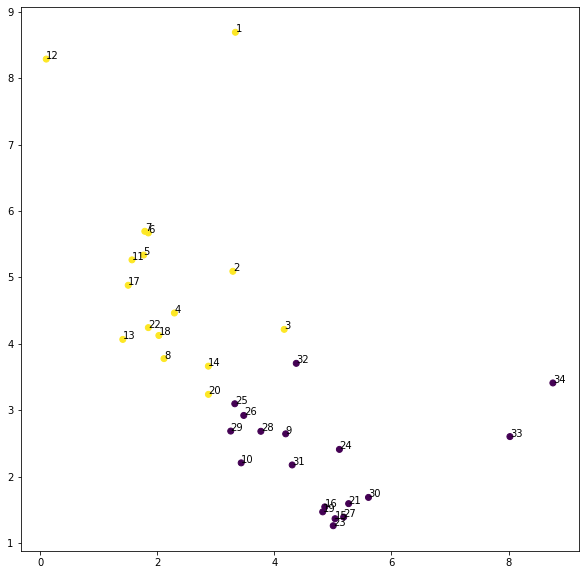

Cross Entropy Loss: = 0.004734792746603489


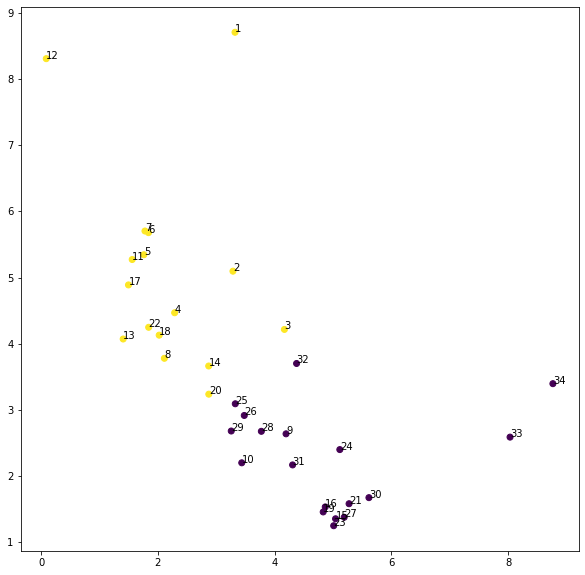

Cross Entropy Loss: = 0.004617978818714619


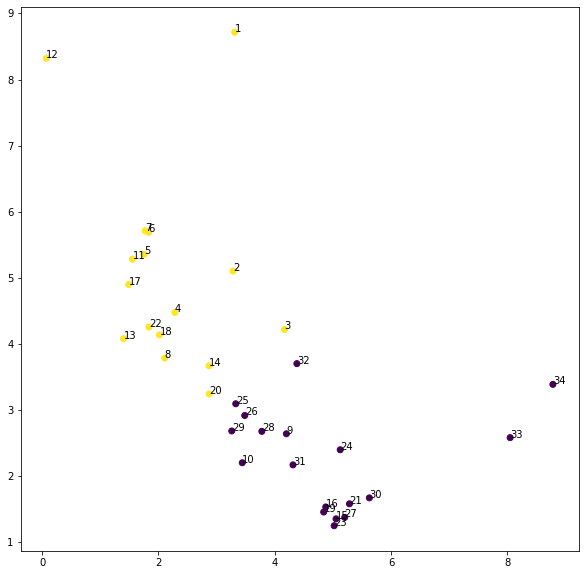

Cross Entropy Loss: = 0.004506313242018223


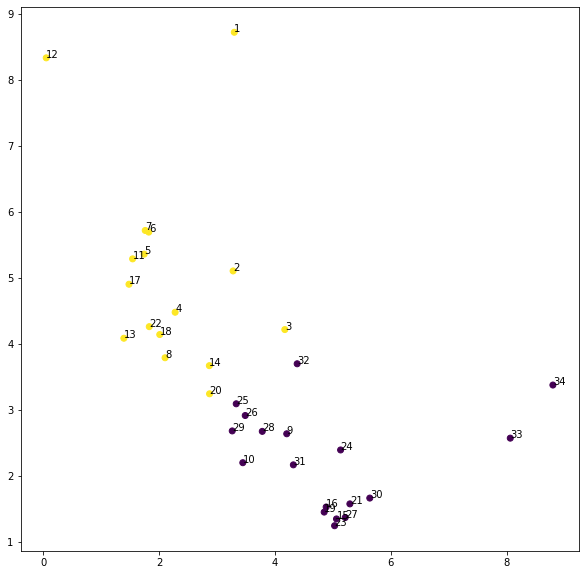

Cross Entropy Loss: = 0.004399382974952459


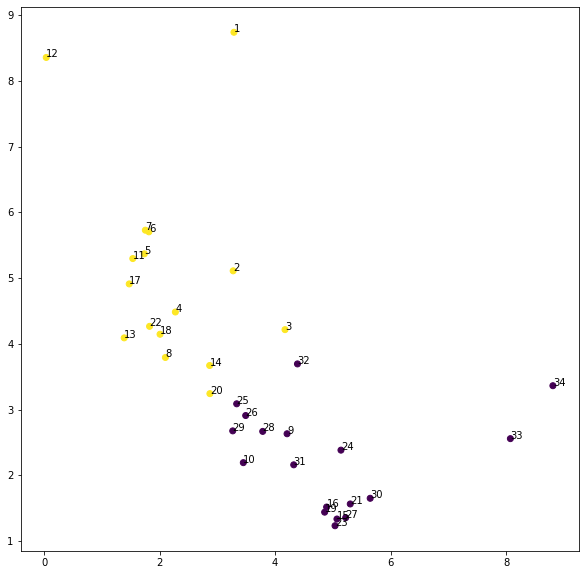

Cross Entropy Loss: = 0.004297070670872927


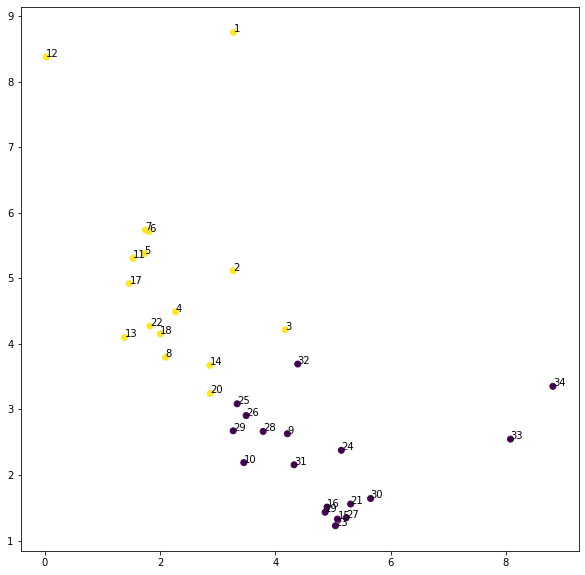

Cross Entropy Loss: = 0.004198902286589146


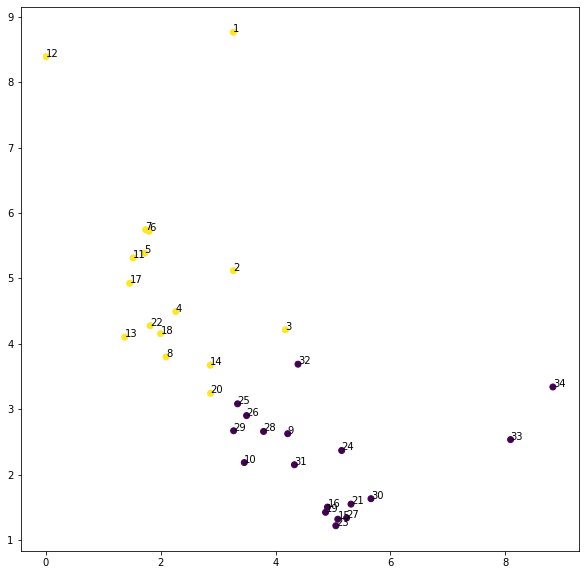

Cross Entropy Loss: = 0.004104820545762777


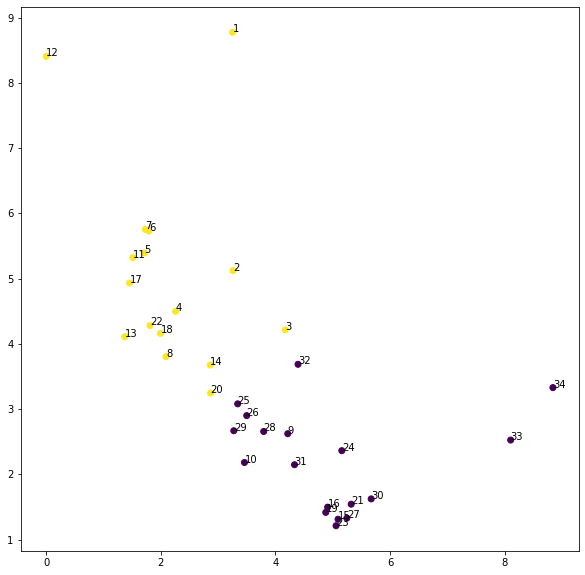

Cross Entropy Loss: = 0.004014410078525543


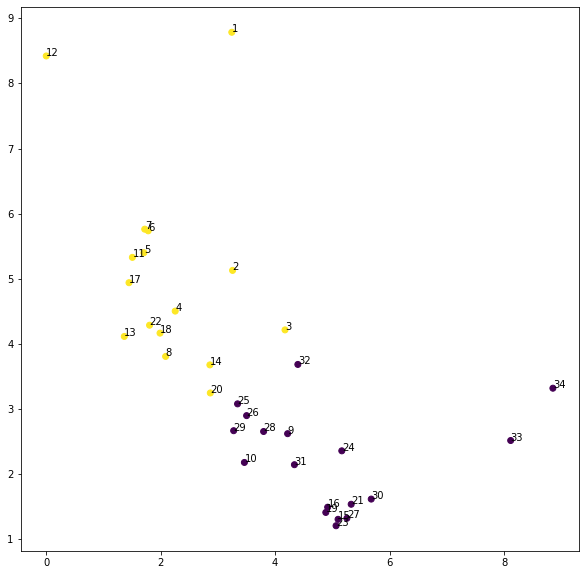

Cross Entropy Loss: = 0.00392767321318388


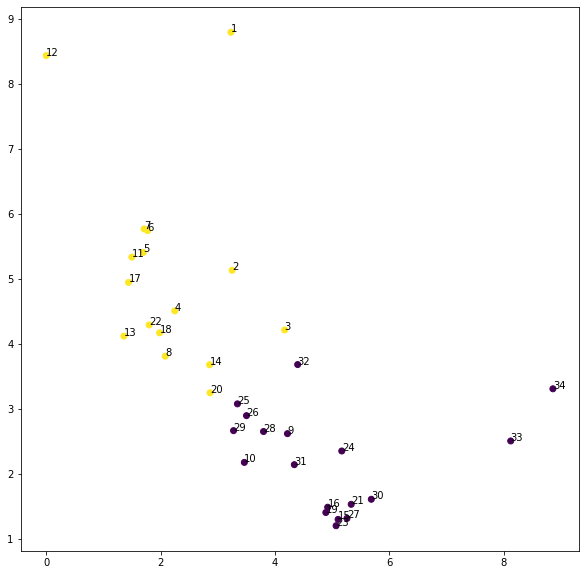

Cross Entropy Loss: = 0.0038441938813775778


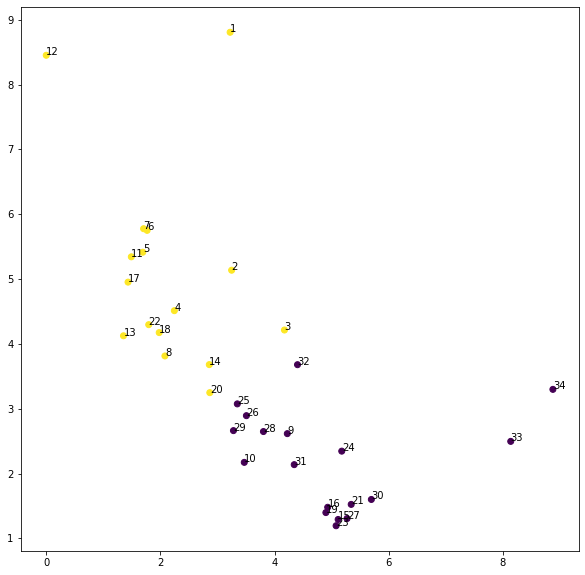

Cross Entropy Loss: = 0.0037639145739376545


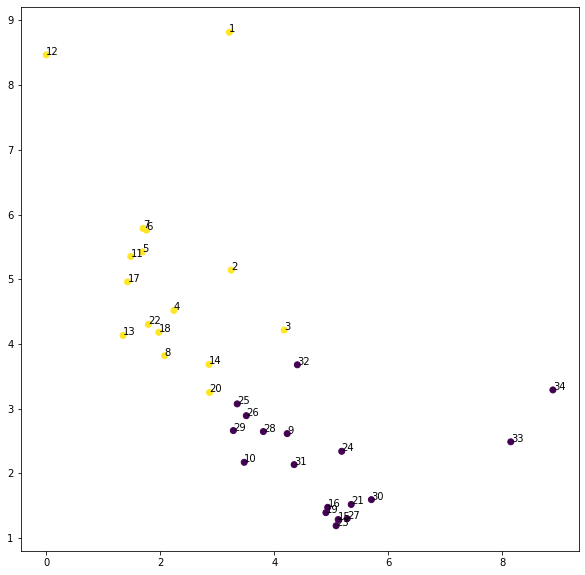

Cross Entropy Loss: = 0.0036866571754217148


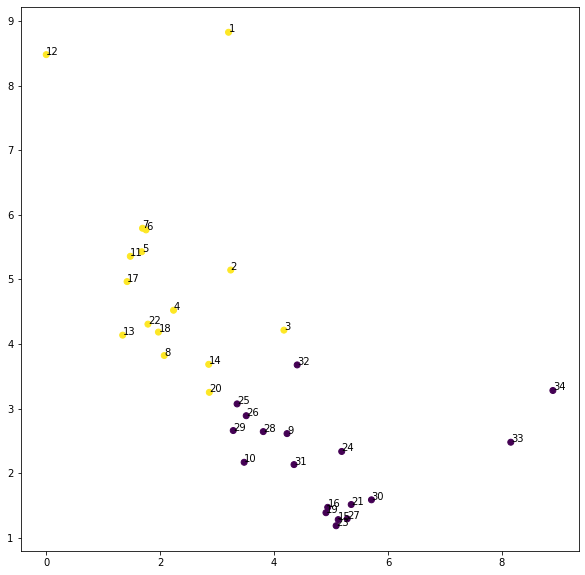

Cross Entropy Loss: = 0.003612244501709938


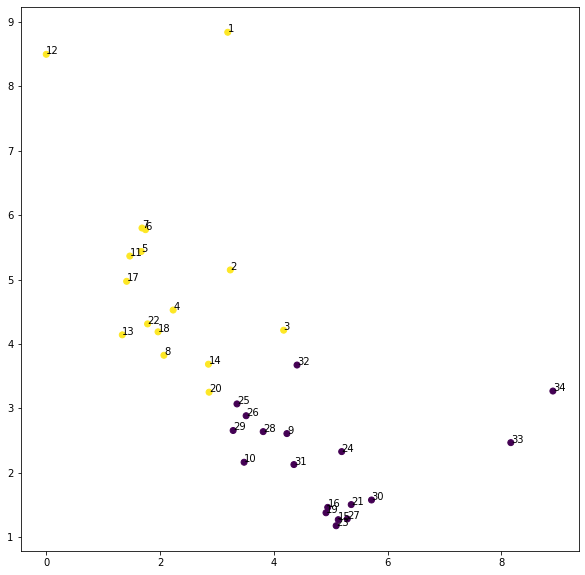

Cross Entropy Loss: = 0.00354049913585186


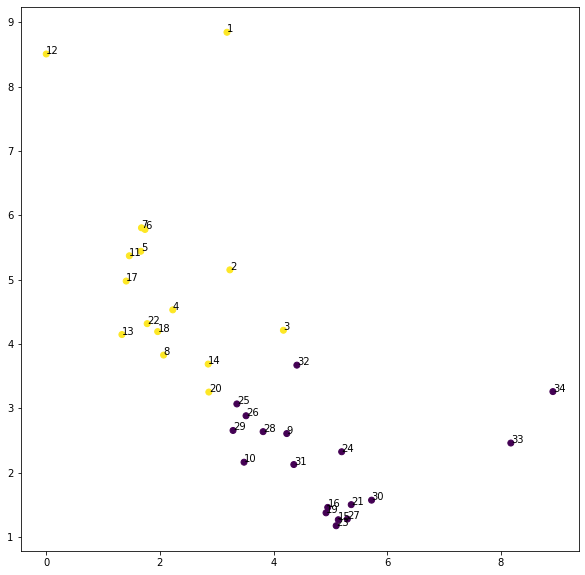

Cross Entropy Loss: = 0.0034713027998805046


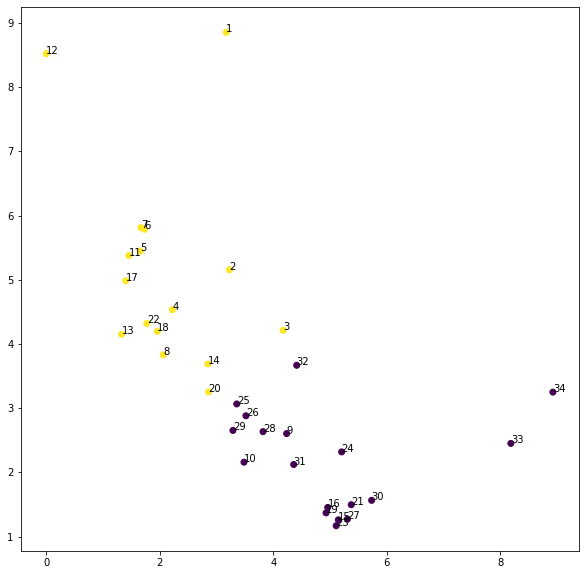

Cross Entropy Loss: = 0.0034045372158288956


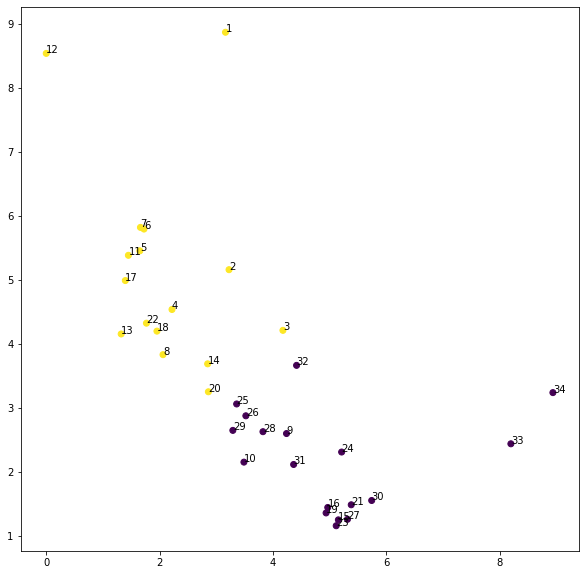

Cross Entropy Loss: = 0.003340083872899413


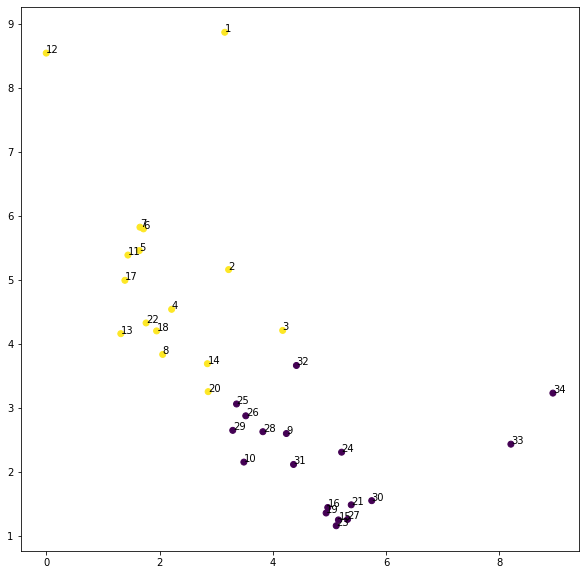

Cross Entropy Loss: = 0.003277824493125081


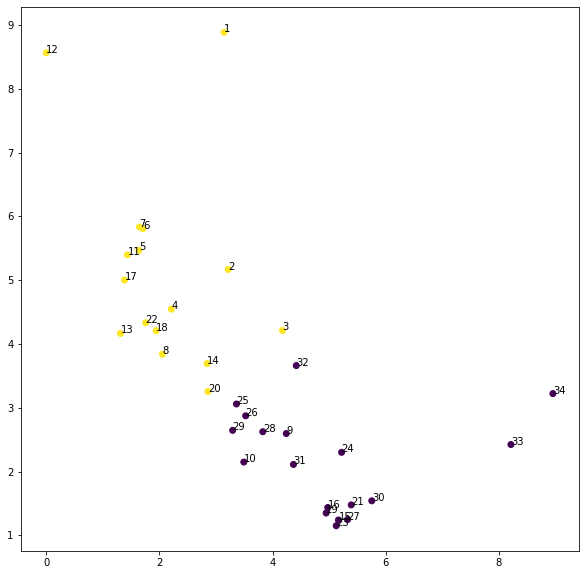

Cross Entropy Loss: = 0.0032176407985389233


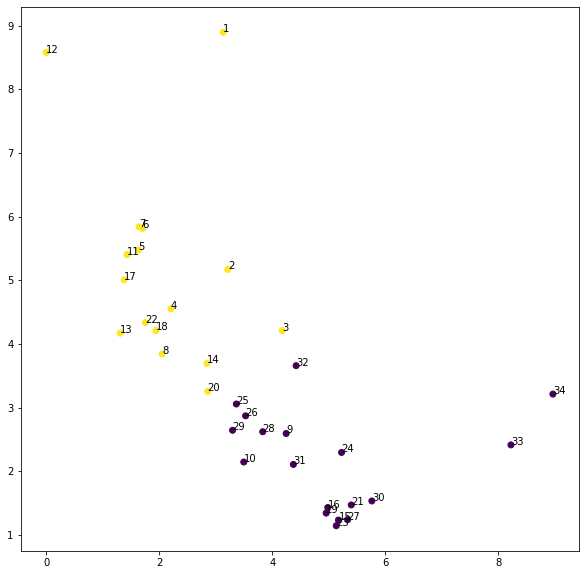

Cross Entropy Loss: = 0.0031594736501574516


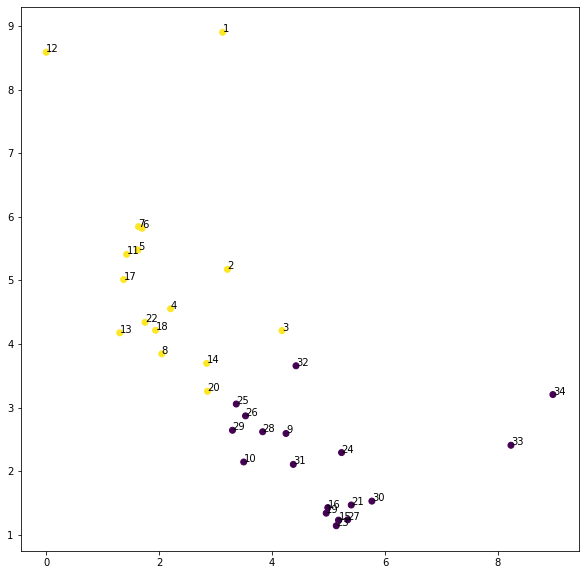

Cross Entropy Loss: = 0.0031031451653689146


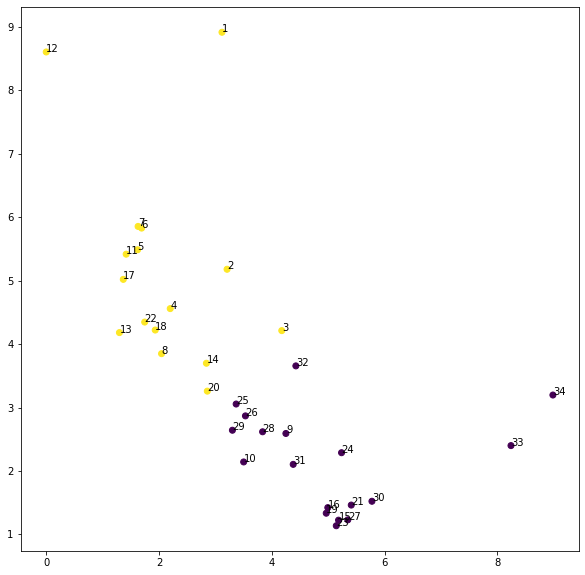

Cross Entropy Loss: = 0.003048655577003956


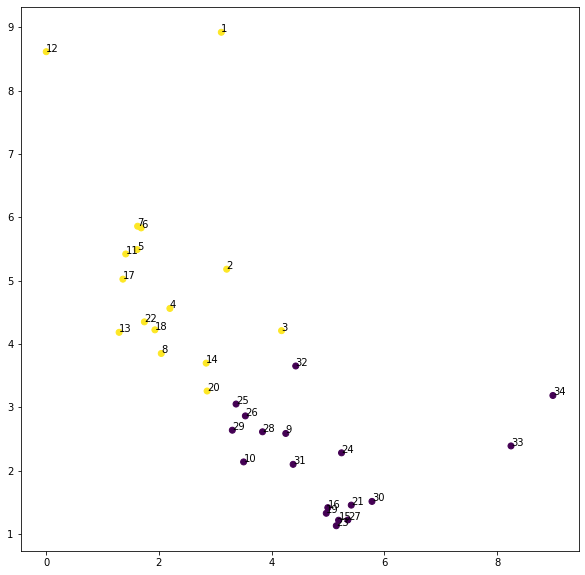

Cross Entropy Loss: = 0.0029959457460790873


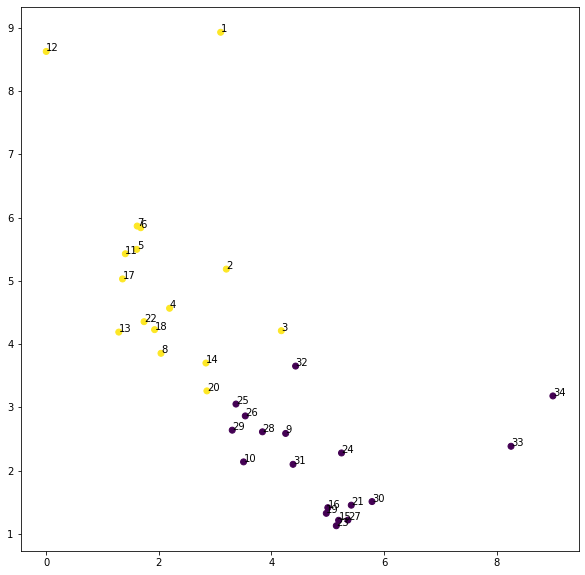

Cross Entropy Loss: = 0.002944778185337782


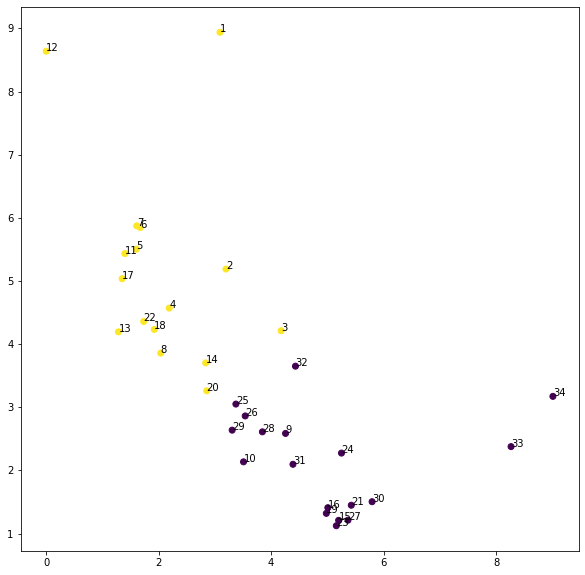

Cross Entropy Loss: = 0.0028952723369002342


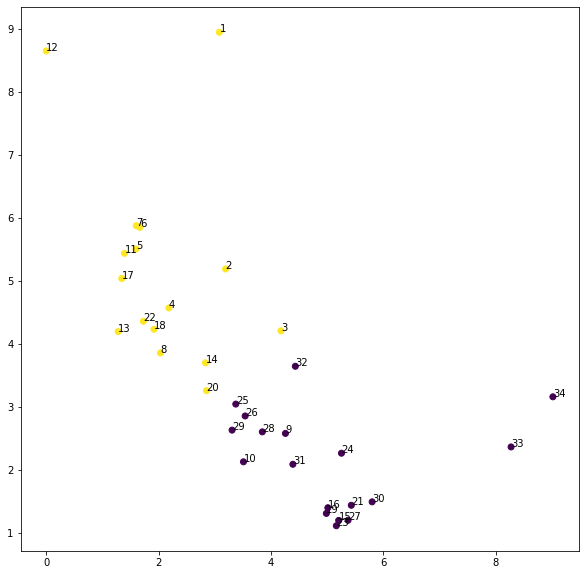

Cross Entropy Loss: = 0.0028471904806792736


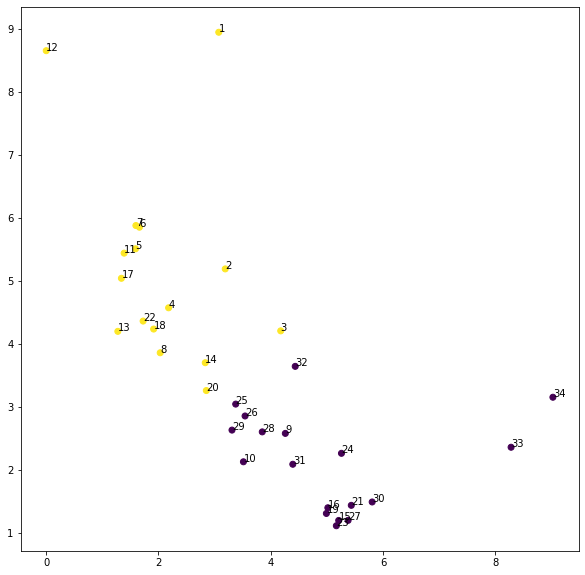

Cross Entropy Loss: = 0.002800651825964451


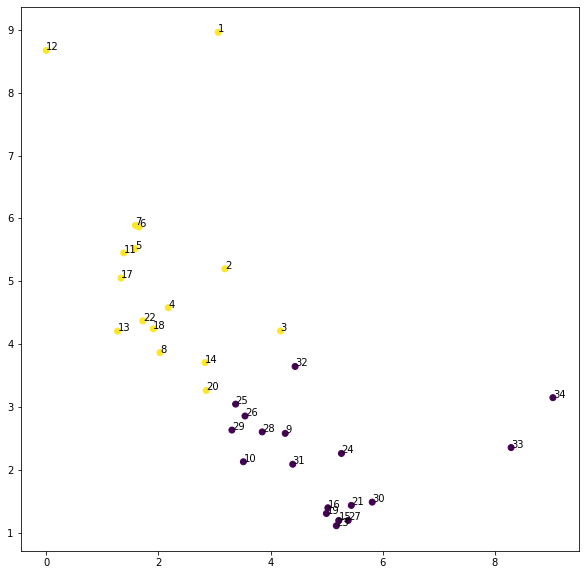

Cross Entropy Loss: = 0.0027554184198379517


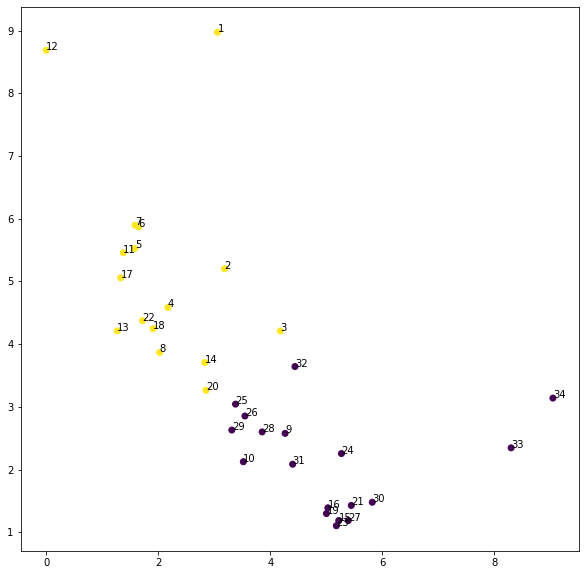

Cross Entropy Loss: = 0.0027114907279610634


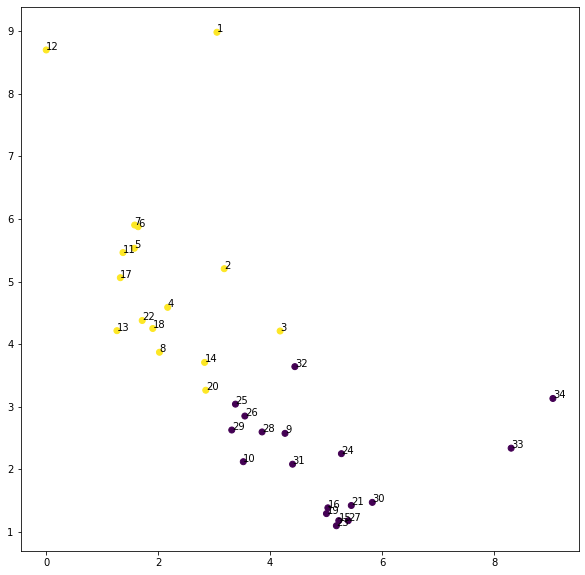

Cross Entropy Loss: = 0.0026688692159950733


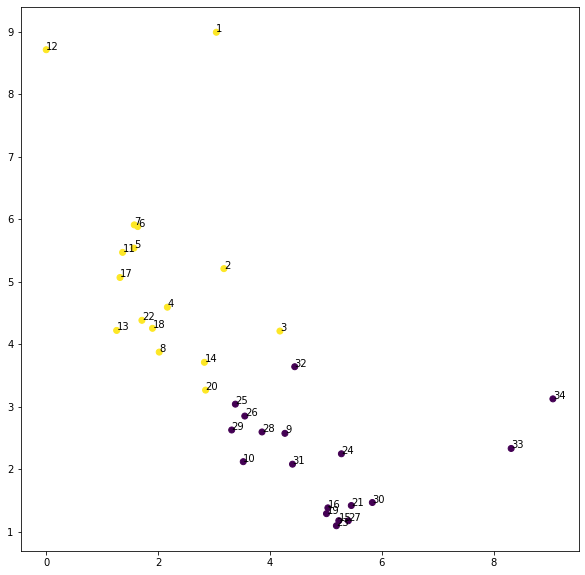

Cross Entropy Loss: = 0.0026273750700056553


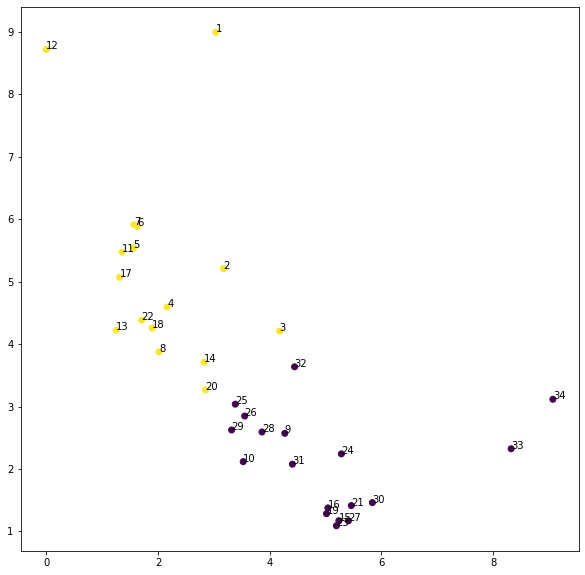

Cross Entropy Loss: = 0.0025871279649436474


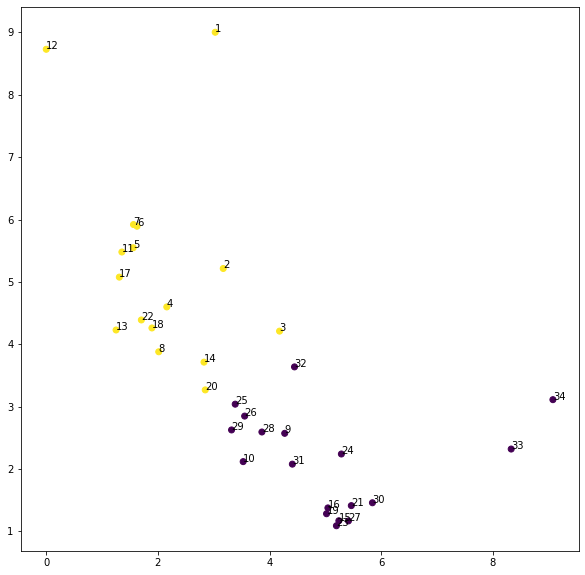

Cross Entropy Loss: = 0.002548008691519499


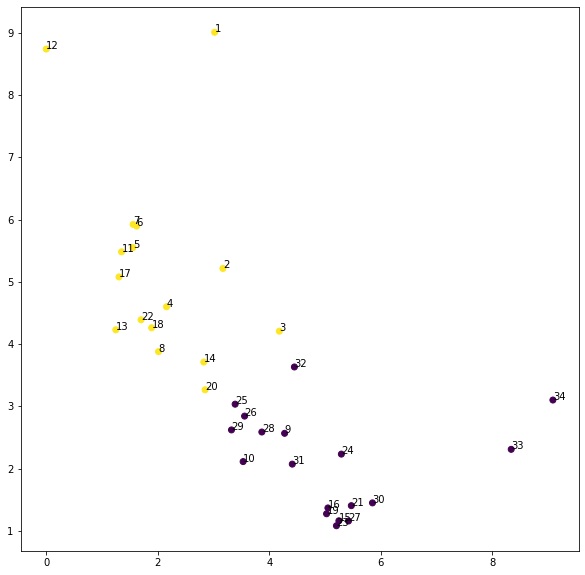

Cross Entropy Loss: = 0.002509898506104946


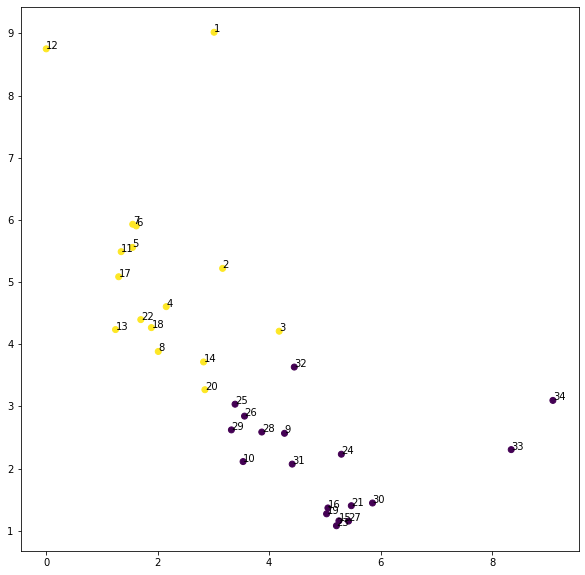

Cross Entropy Loss: = 0.0024728570133447647


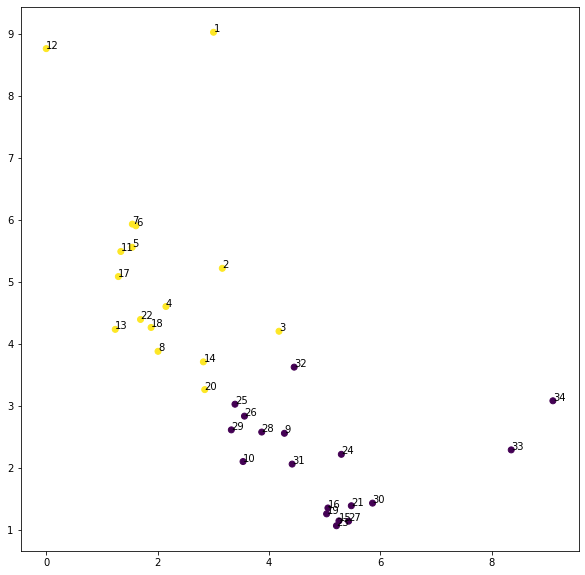

Cross Entropy Loss: = 0.00243682530708611


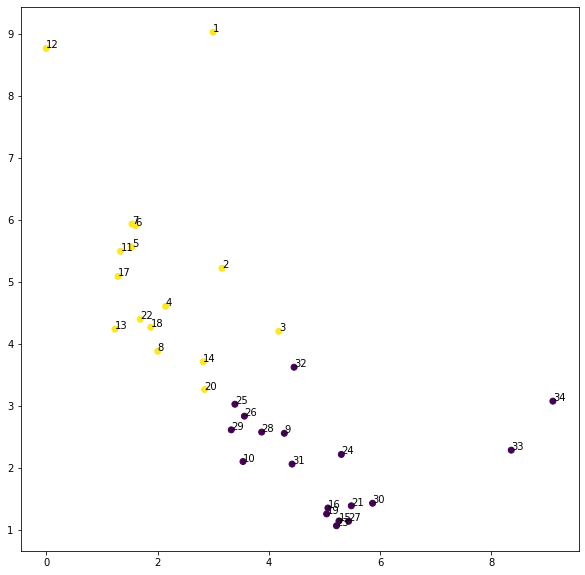

Cross Entropy Loss: = 0.0024017435498535633


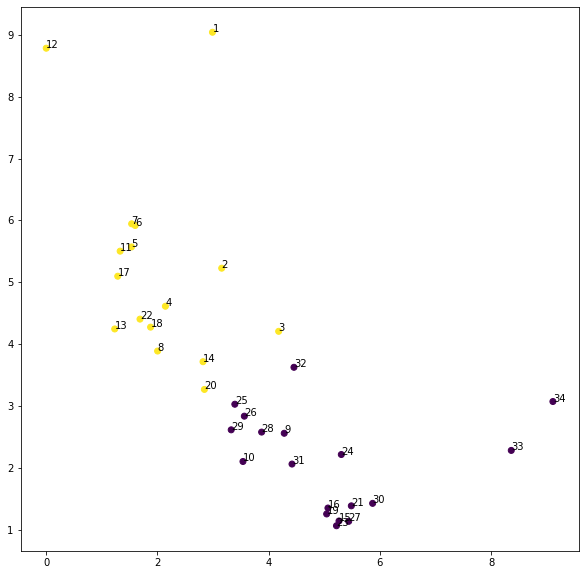

Cross Entropy Loss: = 0.0023674932308495045


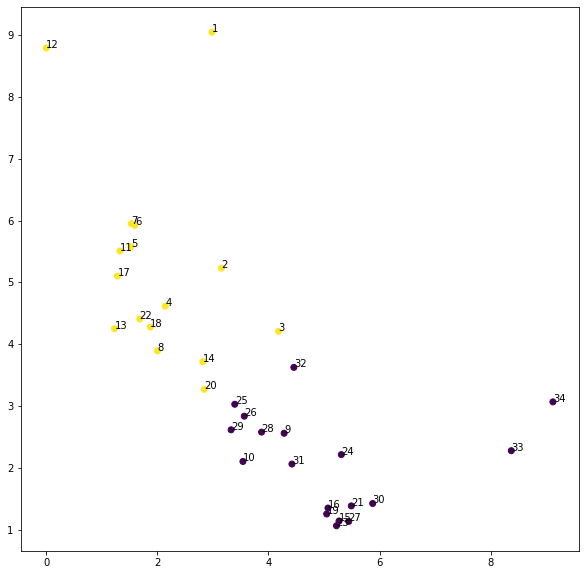

Cross Entropy Loss: = 0.002334252465516329


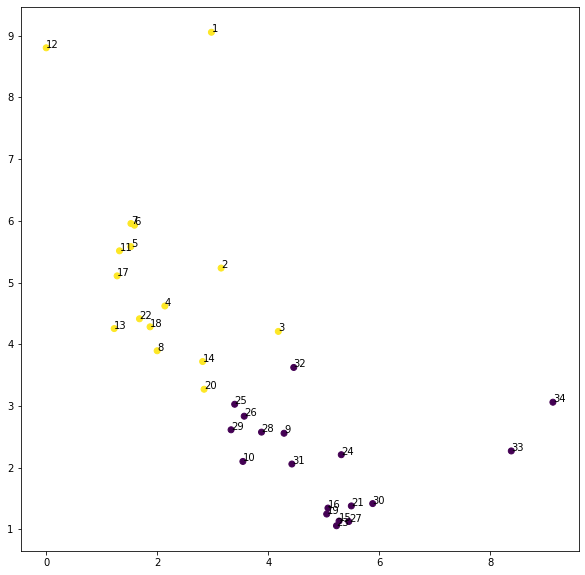

Cross Entropy Loss: = 0.0023017835337668657


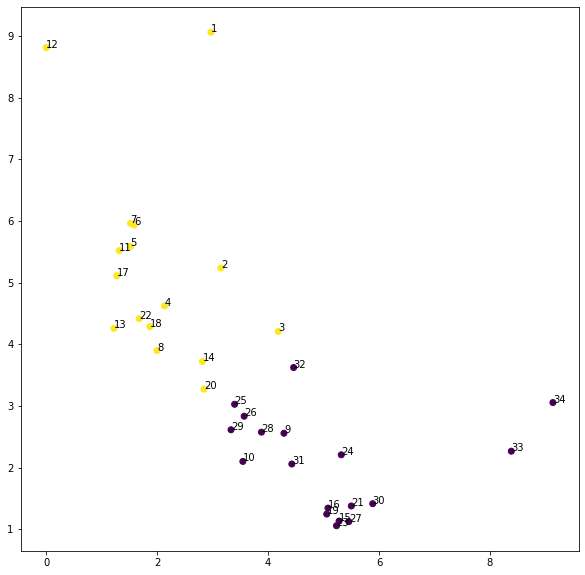

Cross Entropy Loss: = 0.0022701462730765343


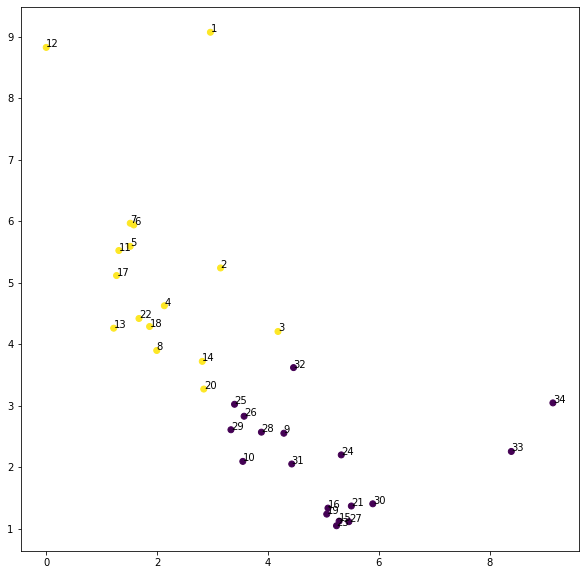

Cross Entropy Loss: = 0.0022392813116312027


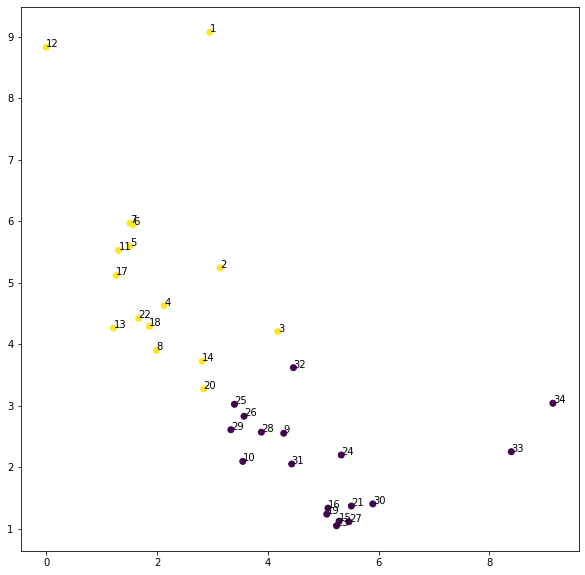

Cross Entropy Loss: = 0.0022091881837695837


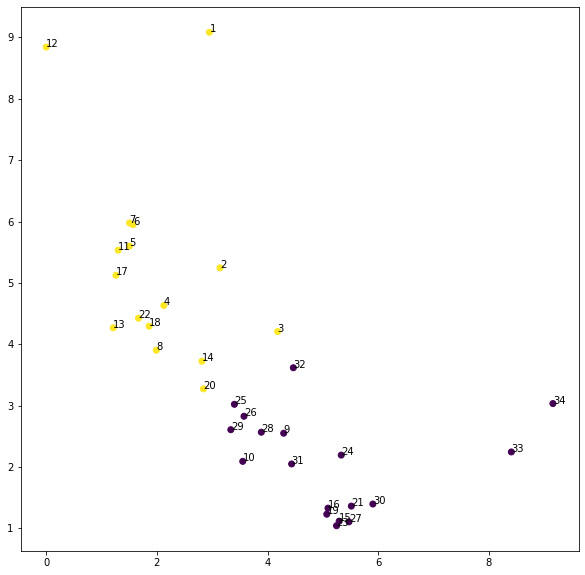

Cross Entropy Loss: = 0.002179807983338833


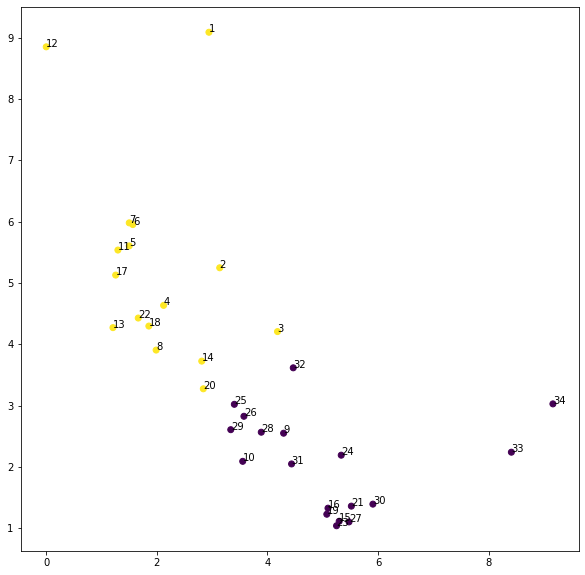

Cross Entropy Loss: = 0.002151200082153082


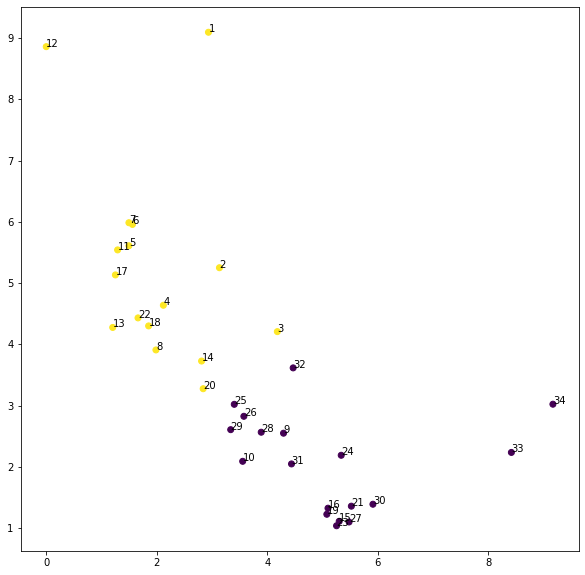

Cross Entropy Loss: = 0.0021233053412288427


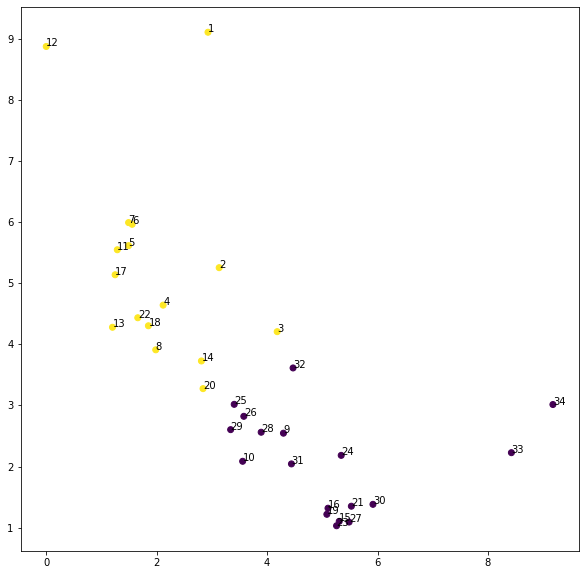

Cross Entropy Loss: = 0.0020961828995496035


In [10]:
for i in range(10000):
    optimizer.zero_grad()
    loss=criterion(T(X), target)
    loss.backward()
    optimizer.step()
    l=(T(X));
    if i%100==0:
        plt.figure(figsize=(10,10))
        plt.scatter(l.detach().numpy()[:,0],l.detach().numpy()[:,1],c=torch.argmax(l, dim=1))
        for i in range(l.shape[0]):
            plt.text(l[i,0], l[i,1], str(i+1))
        plt.show()
        print("Cross Entropy Loss: =",loss.item())

As you can see above it has divided the data in two categories , and its close to the actual predictions. __TODO__ Actual labels.